## Import packages

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import requests
from io import StringIO
import pymc as pm
import arviz as az
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import pytensor.tensor as pt
from pytensor.scan import scan
import xarray as xr
import seaborn as sns
from matplotlib.lines import Line2D

## Set variables

In [11]:
fixed_ndt = 0.25 #s
num_draws = 4000
num_tune = 4000 
targ_accept = 0.9
EPS = 1e-6 #epsilon
wald_model_param_names = ["beta0", "beta1", "beta2", "drift"]
wald_prior_class = "log_normal_prior_centered"
#wald_prior_class = "log_normal_prior_non_centered"


## Helper functions

In [12]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [13]:
def make_trial_table(df):
    rows = []
    for par, df_par in df.groupby('ParticipantID'):
        rounds_list = np.unique(df_par['ExperimentRoundNumber'])
        rounds_list = [int(x) for x in rounds_list if x > 0]
        for r in rounds_list:
            df_round = df_par[df_par['ExperimentRoundNumber'] == r]
            #if df_round.empty:
            #    continue
            #if df_round['MissedMaxDeadline'].iloc[0] == 0:
            #    deadline = df_round['GambleFinalDeadline'].iloc[0]     
            #else:
            #    deadline = df_round['ResponseTimeGamble'].iloc[0]
                
            tt = float(df_round['GambleFinalDeadline'].iloc[0])
            rt  = float(df_round['ResponseTimeGamble'].iloc[0])
            wt  = float(tt - rt)               
            rep = float(df_round['ReproducedTime'].iloc[0])

            rows.append(dict(ParticipantID=par,
                             round=r,
                             rt=rt,
                             wt=wt,
                             tt=tt,
                             reproduced=rep))
    return pd.DataFrame(rows)

## Import data 

In [14]:
try:
    df_processed_reproduction_task_data = pd.read_csv(
        "../data_preprocessing/processed_data/processed_reproduction_task_data.csv"
    )
    print("Successfully loaded processed_reproduction_task_data.csv")
except FileNotFoundError:
    print("File not found. Please run the preprocessing pipeline first to generate 'processed_reproduction_task_data.csv'.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded processed_reproduction_task_data.csv


In [15]:
par_ids = np.unique(df_processed_reproduction_task_data['ParticipantID'])
n_par = len(par_ids)

## Format data for fitting  procedure

In [16]:
trial_df = make_trial_table(df_processed_reproduction_task_data).reset_index(drop=True)

# index participants 0..N-1 for vectorized modeling
participants = trial_df['ParticipantID'].unique()
pid_to_idx = {pid:i for i,pid in enumerate(participants)}
trial_df['subj_idx'] = trial_df['ParticipantID'].map(pid_to_idx).astype(int)

# numpy arrays for PyMC
rt  = trial_df['rt'].to_numpy(float)
wt  = trial_df['wt'].to_numpy(float)
tt  = trial_df['tt'].to_numpy(float)
rep = trial_df['reproduced'].to_numpy(float)
subj_idx = trial_df['subj_idx'].to_numpy(int)

n_obs  = rt.size
n_subj = len(participants)

par_ids = trial_df["ParticipantID"].unique()

## Fit null hypothesis

In [17]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}


if wald_prior_class in ["log_normal_prior_non_centered","log_normal_prior_centered"]:
    
    with pm.Model(coords=coords) as h_wald_null:
        # ----- data  -----

        subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")
    
        # ===== group-level priors on log scale =====
    
        group_log_beta0_mu, group_log_beta0_sigma = pm.Normal("group_log_beta0_mu", 2, 0.5), pm.HalfNormal("group_log_beta0_sigma", 0.5)

        group_log_drift_mu    = pm.Normal("group_log_drift_mu", 0.5, 0.5)
        group_log_drift_sigma = pm.HalfNormal("group_log_drift_sigma", 0.5)

        if wald_prior_class == "log_normal_prior_centered":    
    
            # ===== individual-level parameters  =====
            indi_log_beta0 = pm.Normal("indi_log_beta0", mu=group_log_beta0_mu, sigma=group_log_beta0_sigma, dims="subject")
            indi_log_drift = pm.Normal("indi_log_drift", mu=group_log_drift_mu, sigma=group_log_drift_sigma, dims="subject")

        elif wald_prior_class == "log_normal_prior_non_centered":   
            # ===== subject-level parameters (NON-CENTERED) =====
            z_b0 = pm.Normal("z_b0", 0.0, 1.0, dims="subject")
            z_d  = pm.Normal("z_drift", 0.0, 1.0, dims="subject")
        
            indi_log_beta0 = pm.Deterministic("indi_log_beta0", group_log_beta0_mu + group_log_beta0_sigma * z_b0, dims="subject")
            indi_log_drift = pm.Deterministic("indi_log_drift", group_log_drift_mu + group_log_drift_sigma * z_d,  dims="subject")
        
        indi_beta0 = pm.Deterministic("indi_beta0", pt.exp(indi_log_beta0), dims="subject")
        indi_drift = pm.Deterministic("indi_drift", pt.exp(indi_log_drift), dims="subject")
            
    
        # ===== trial-level link =====
        i = pm.intX(subj_dat)  # map each trial to its subject
        
        alpha_n   = pm.Deterministic(
            "alpha_n",
            indi_beta0[i],
            dims="obs"
        )
    
        mu_n  = alpha_n / (indi_drift[i] + 1e-9) 
        lam_n = alpha_n**2
    
        pm.Wald("reproduced_times", mu=mu_n, lam=lam_n, alpha = fixed_ndt, observed=rep, dims="obs")
    

        # ===== sampling =====
        
        idata_wald_null = pm.sample(
            draws=num_draws,
            tune=num_tune,
            target_accept=targ_accept,
            chains=4,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )
        ppc_wald_null = pm.sample_posterior_predictive(idata_wald_null, var_names=["reproduced_times","alpha_n"])
    
    post = idata_wald_null.posterior
    idata_wald_null.posterior = post.assign(
        group_beta0_mu = np.exp(post["group_log_beta0_mu"]),
        group_drift_mu = np.exp(post["group_log_drift_mu"]),
    
        # on original scale these are geometric SDs
        group_beta0_sigma = np.exp(post["group_log_beta0_sigma"]),
        group_drift_sigma = np.exp(post["group_log_drift_sigma"]),
    )
    
    wald_null_fitting_summary = az.summary(idata_wald_null)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_log_beta0_mu, group_log_beta0_sigma, group_log_drift_mu, group_log_drift_sigma, indi_log_beta0, indi_log_drift]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 148 seconds.
Sampling: [reproduced_times]


Output()

In [18]:
az.to_netcdf(idata_wald_null, f"idata_wald_null_{wald_prior_class}.nc")    

'idata_null_log_normal_prior_centered.nc'

In [42]:
with h_wald_null:
    prior_pred_wald_null = pm.sample_prior_predictive(500, var_names=["reproduced_times","alpha_n"])  
y_prior_wald_null = prior_pred_wald_null.prior_predictive["reproduced_times"].values.ravel()

Sampling: [group_log_beta0_mu, group_log_beta0_sigma, group_log_drift_mu, group_log_drift_sigma, indi_log_beta0, indi_log_drift, reproduced_times]


## Fit Wald model

In [24]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}


if wald_prior_class in ["log_normal_prior_non_centered","log_normal_prior_centered"]:
    
    with pm.Model(coords=coords) as h_wald:
        # ----- data  -----
        rt_dat   = pm.Data("rt", rt, dims="obs")
        wt_dat   = pm.Data("wt", wt, dims="obs")
        subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")
    
        # ===== group-level priors on log scale =====
    
        group_log_beta0_mu, group_log_beta0_sigma = pm.Normal("group_log_beta0_mu", 0, 0.5), pm.HalfNormal("group_log_beta0_sigma", 0.5)
        group_log_beta1_mu, group_log_beta1_sigma = pm.Normal("group_log_beta1_mu", 0, 0.5), pm.HalfNormal("group_log_beta1_sigma", 0.5)
        group_log_beta2_mu, group_log_beta2_sigma = pm.Normal("group_log_beta2_mu", 0, 0.5), pm.HalfNormal("group_log_beta2_sigma", 0.5)
    
        group_log_drift_mu    = pm.Normal("group_log_drift_mu", 0.5, 0.5)
        group_log_drift_sigma = pm.HalfNormal("group_log_drift_sigma", 0.5)

        if wald_prior_class == "log_normal_prior_centered":    
    
            # ===== individual-level parameters  =====
            indi_log_beta0 = pm.Normal("indi_log_beta0", mu=group_log_beta0_mu, sigma=group_log_beta0_sigma, dims="subject")
            indi_log_beta1 = pm.Normal("indi_log_beta1", mu=group_log_beta1_mu, sigma=group_log_beta1_sigma, dims="subject")
            indi_log_beta2 = pm.Normal("indi_log_beta2", mu=group_log_beta2_mu, sigma=group_log_beta2_sigma, dims="subject")
            indi_log_drift = pm.Normal("indi_log_drift", mu=group_log_drift_mu, sigma=group_log_drift_sigma, dims="subject")

        elif wald_prior_class == "log_normal_prior_non_centered":   
            # ===== subject-level parameters (NON-CENTERED) =====
            z_b0 = pm.Normal("z_b0", 0.0, 1.0, dims="subject")
            z_b1 = pm.Normal("z_b1", 0.0, 1.0, dims="subject")
            z_b2 = pm.Normal("z_b2", 0.0, 1.0, dims="subject")
            z_d  = pm.Normal("z_drift", 0.0, 1.0, dims="subject")
        
            indi_log_beta0 = pm.Deterministic("indi_log_beta0", group_log_beta0_mu + group_log_beta0_sigma * z_b0, dims="subject")
            indi_log_beta1 = pm.Deterministic("indi_log_beta1", group_log_beta1_mu + group_log_beta1_sigma * z_b1, dims="subject")
            indi_log_beta2 = pm.Deterministic("indi_log_beta2", group_log_beta2_mu + group_log_beta2_sigma * z_b2, dims="subject")
            indi_log_drift = pm.Deterministic("indi_log_drift", group_log_drift_mu + group_log_drift_sigma * z_d,  dims="subject")
        
        indi_beta0 = pm.Deterministic("indi_beta0", pt.exp(indi_log_beta0), dims="subject")
        indi_beta1 = pm.Deterministic("indi_beta1", pt.exp(indi_log_beta1), dims="subject")
        indi_beta2 = pm.Deterministic("indi_beta2", pt.exp(indi_log_beta2), dims="subject")
        indi_drift = pm.Deterministic("indi_drift", pt.exp(indi_log_drift), dims="subject")
            
    
        # ===== trial-level link =====
        i = pm.intX(subj_dat)  # map each trial to its subject
        
        alpha_n   = pm.Deterministic(
            "alpha_n",
            indi_beta0[i] + indi_beta1[i]*rt_dat + indi_beta2[i]*wt_dat,
            dims="obs"
        )
    
        mu_n  = alpha_n / (indi_drift[i] + 1e-9) 
        lam_n = alpha_n**2
    
        pm.Wald("reproduced_times", mu=mu_n, lam=lam_n, alpha = fixed_ndt, observed=rep, dims="obs")
    
        # ===== sampling =====
        
        idata_wald = pm.sample(
            draws=num_draws,
            tune=num_tune,
            target_accept=targ_accept,
            chains=4,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )
        ppc_wald = pm.sample_posterior_predictive(idata_wald, var_names=["reproduced_times","alpha_n"])
    
    post = idata_wald.posterior
    idata_wald.posterior = post.assign(
        group_beta0_mu = np.exp(post["group_log_beta0_mu"]),
        group_beta1_mu = np.exp(post["group_log_beta1_mu"]),
        group_beta2_mu = np.exp(post["group_log_beta2_mu"]),
        group_drift_mu = np.exp(post["group_log_drift_mu"]),
    
        # on original scale these are geometric SDs
        group_beta0_sigma = np.exp(post["group_log_beta0_sigma"]),
        group_beta1_sigma = np.exp(post["group_log_beta1_sigma"]),
        group_beta2_sigma = np.exp(post["group_log_beta2_sigma"]),
        group_drift_sigma = np.exp(post["group_log_drift_sigma"]),
    )
    
    wald_fitting_summary = az.summary(idata_wald)
    
    


In [33]:
az.to_netcdf(idata_wald, f"idata_wald_{wald_prior_class}.nc")     

'idata_wald_log_normal_prior_centered.nc'

### Prior predictive check 

In [25]:
with h_wald:
    prior_pred_wald = pm.sample_prior_predictive(500, var_names=["reproduced_times","alpha_n"])  
y_prior_wald = prior_pred_wald.prior_predictive["reproduced_times"].values.ravel()

Sampling: [group_log_beta0_mu, group_log_beta0_sigma, group_log_beta1_mu, group_log_beta1_sigma, group_log_beta2_mu, group_log_beta2_sigma, group_log_drift_mu, group_log_drift_sigma, indi_log_beta0, indi_log_beta1, indi_log_beta2, indi_log_drift, reproduced_times]


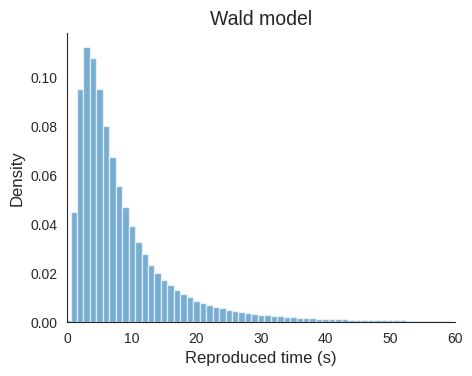

In [67]:


plt.figure(figsize=(5, 3.75))
sns.set_style("white") 
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],  
})
plt.hist(y_prior_wald, bins=np.arange(-0.5, 60.5, 1), density=True, alpha=0.6, color="C0")
plt.xlabel("Reproduced time (s)", fontsize = 12)
plt.ylabel("Density", fontsize = 12)
plt.title("Wald model", fontsize = 14)
plt.xlim(0, 60)
sns.despine(top=True, right=True)  
#plt.savefig("../figures/wald_model_prior_predictive.svg", format="svg", bbox_inches="tight")
plt.show()

### Fitted individual-level parameter results

##### Visualize fitted params

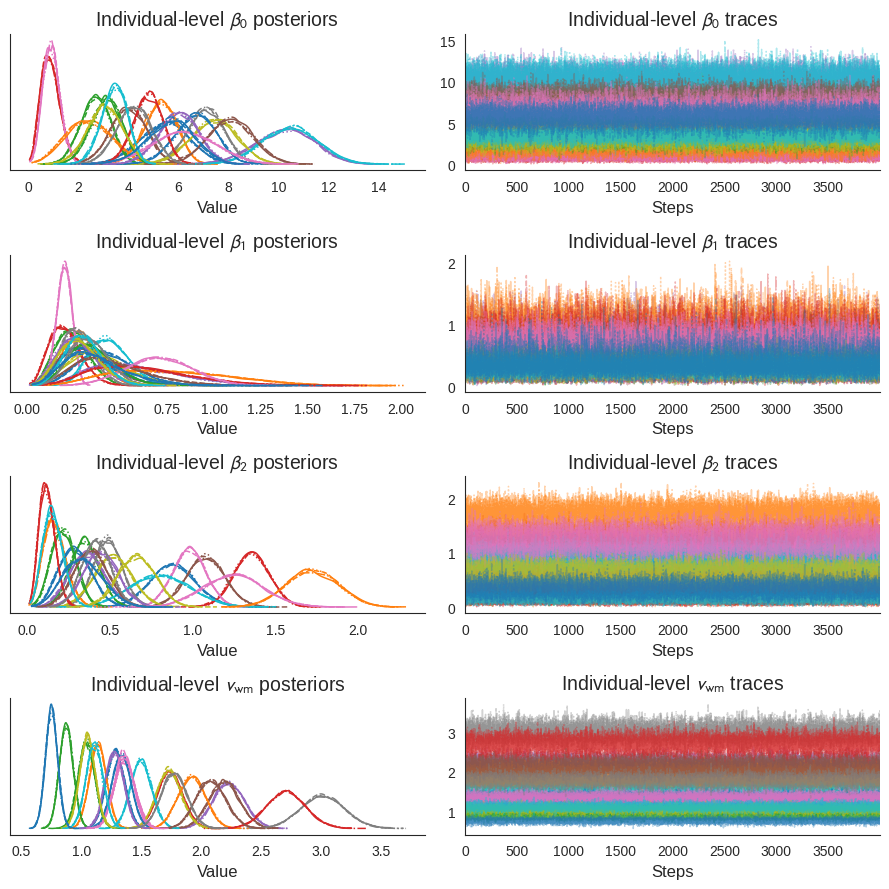

In [14]:
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,  # keep False if you don't have LaTeX installed
    "mathtext.fontset": "stixsans",  # matches sans-serif aesthetic
})

axes = az.plot_trace(idata_wald, var_names=["indi_beta0", "indi_beta1", "indi_beta2", "indi_drift"])


fig = axes[0,0].figure

fig.set_size_inches(9, 9)

plt.tight_layout(pad=2.0)
fig.subplots_adjust(hspace=0.6)

custom_titles_left = [r"Individual-level $\beta_{0}$ posteriors", 
                      r"Individual-level $\beta_{1}$ posteriors",
                      r"Individual-level $\beta_{2}$ posteriors",
                      r"Individual-level $v_{\text{wm}}$ posteriors"]

custom_titles_right = [r"Individual-level $\beta_{0}$ traces", 
                      r"Individual-level $\beta_{1}$ traces",
                      r"Individual-level $\beta_{2}$ traces",
                      r"Individual-level $v_{\text{wm}}$ traces"]


for i, title in enumerate(custom_titles_left):
    axes[i, 0].set_title(title, fontsize = 14)
    axes[i, 0].set_xlabel("Value", fontsize = 12)

for i, title in enumerate(custom_titles_right):  
    axes[i, 1].set_title(title, fontsize = 14)
    axes[i, 1].set_xlabel("Steps", fontsize = 12)

for row in axes:
    for ax in row:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)


plt.tight_layout()

# make sure the folder exists
outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, f"fitted_params_indi_level_wald_{wald_prior_class}.png")
plt.savefig(out_figure_path, dpi=300, bbox_inches='tight')

plt.show()

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (84) in plot_posterior, generating only 40 plots
  warnings.warn(


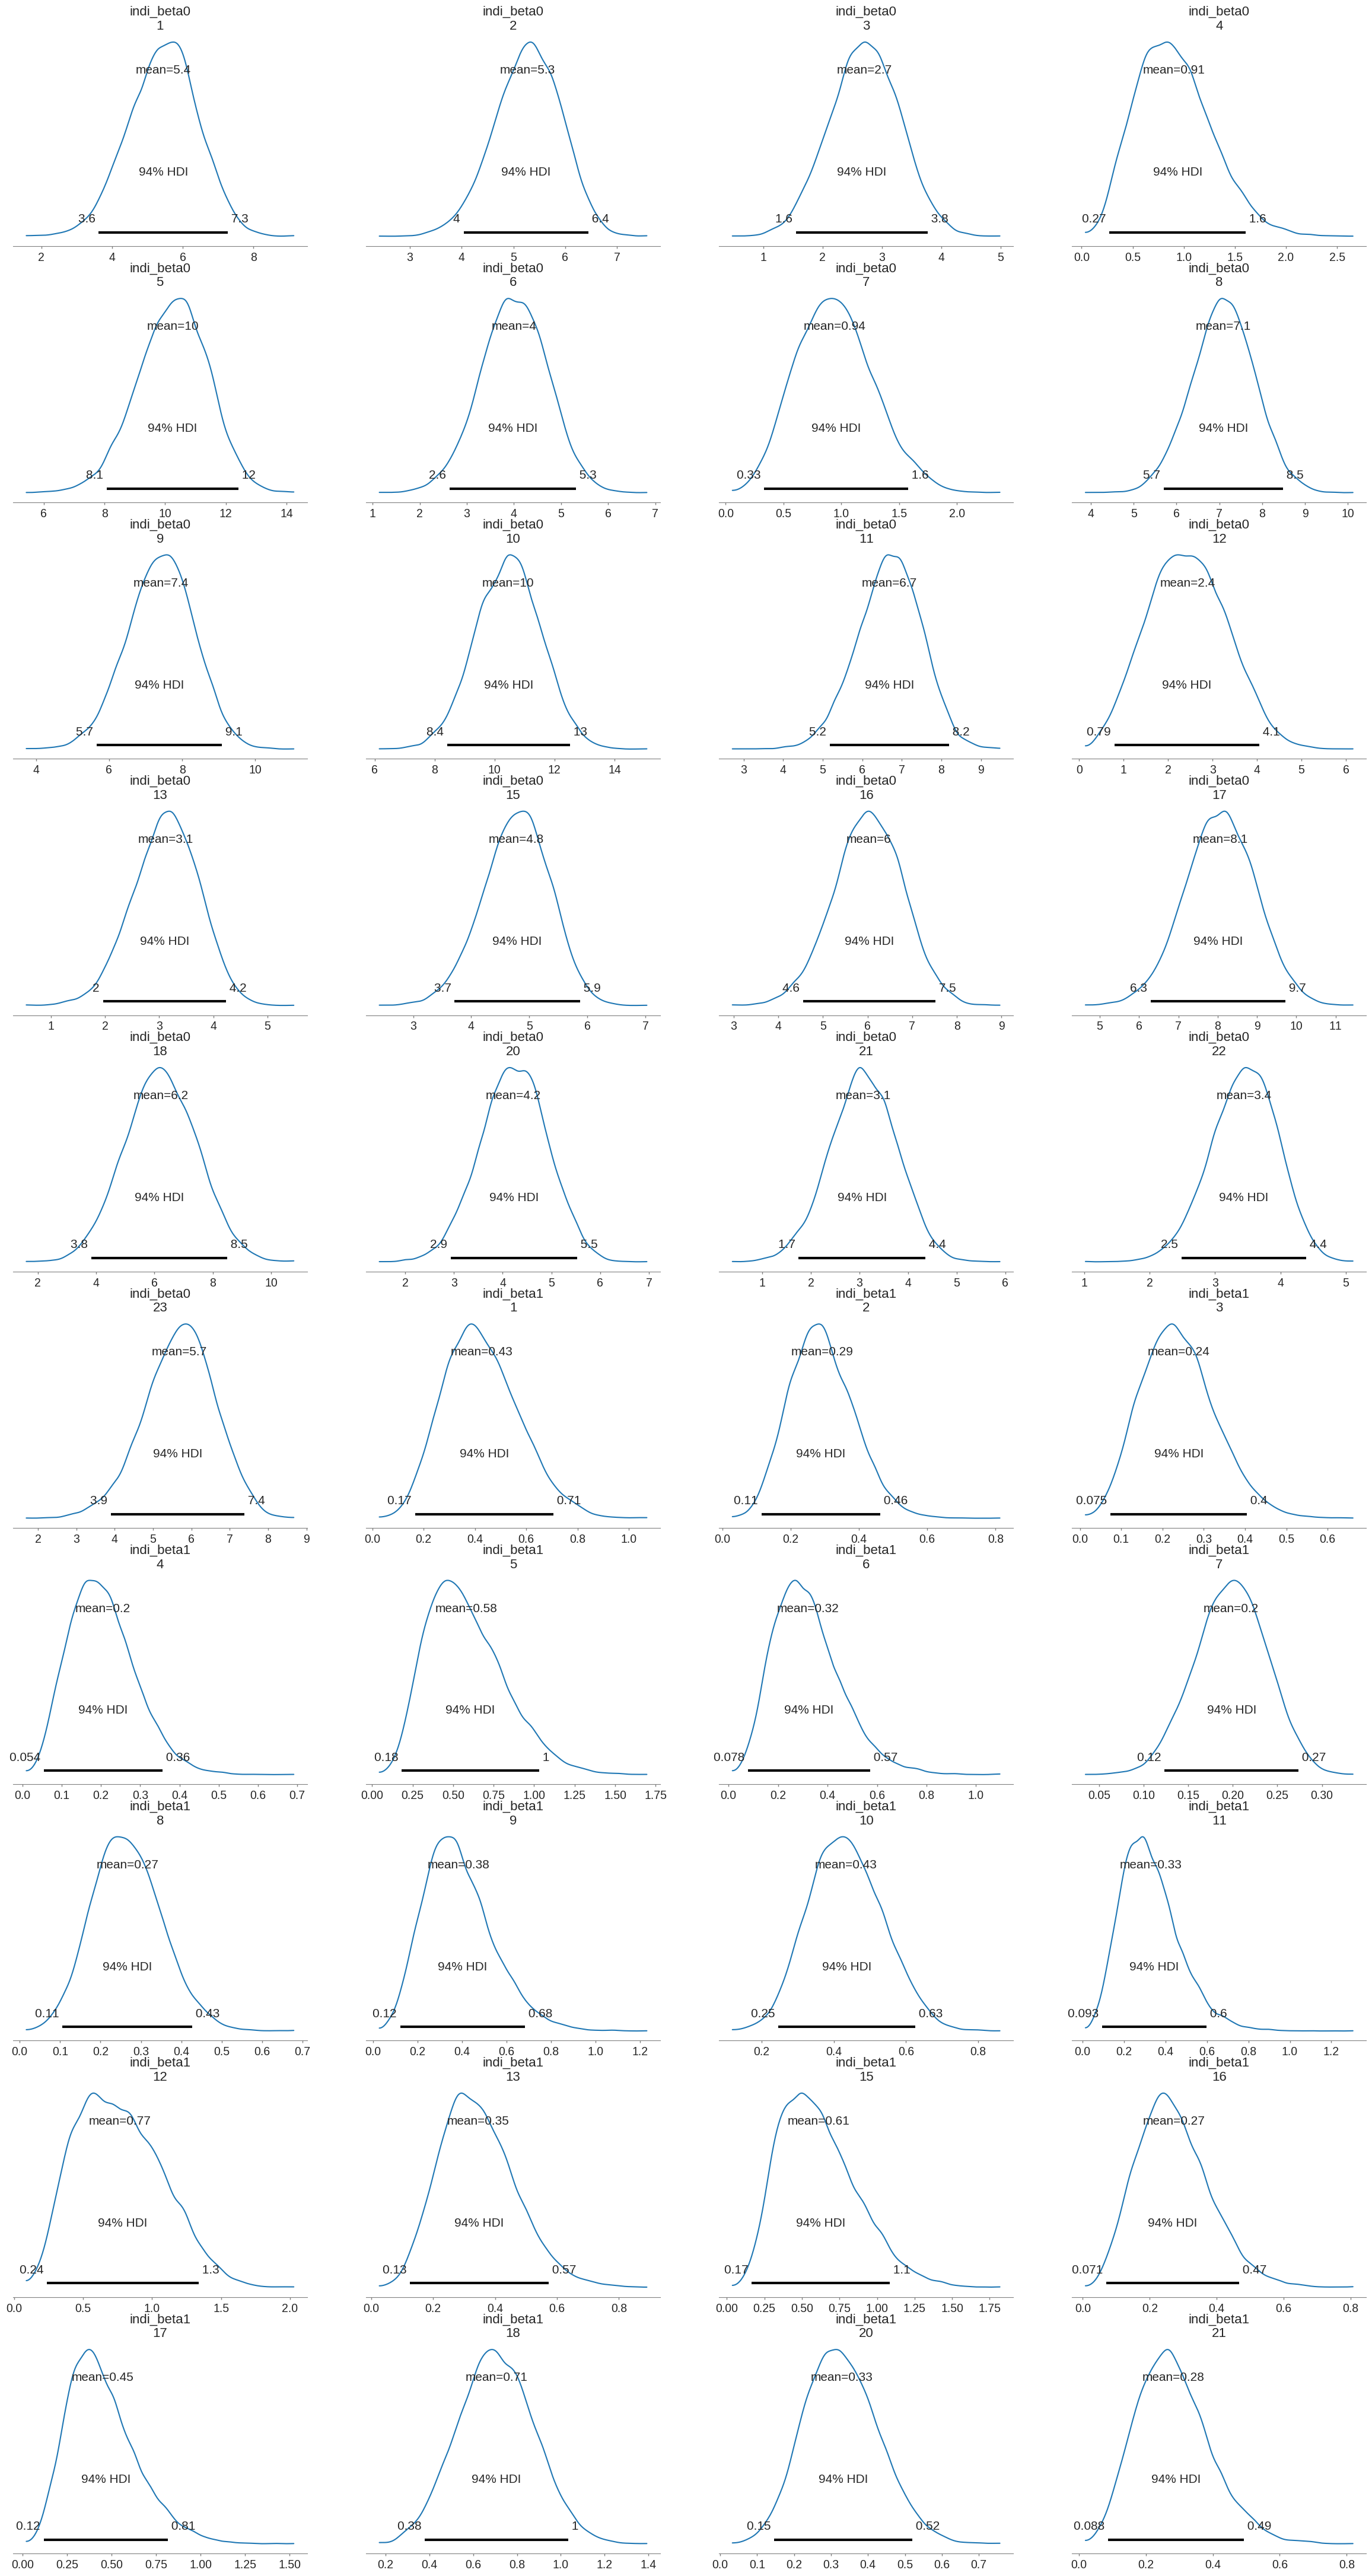

In [15]:
az.plot_posterior(idata_wald, var_names=["indi_beta0","indi_beta1","indi_beta2", "indi_drift"]);

##### Save individual-level fitted parameters

In [16]:
rows = []

for par in par_ids:
    
    df_row_beta0 = wald_fitting_summary.loc[f'indi_beta0[{par}]']
    df_row_beta1 = wald_fitting_summary.loc[f'indi_beta1[{par}]']
    df_row_beta2 = wald_fitting_summary.loc[f'indi_beta2[{par}]']
    df_row_drift = wald_fitting_summary.loc[f'indi_drift[{par}]']

    rows.append({
        'Participant_ID': par,
        
        'indi_beta0_mean': df_row_beta0['mean'],
        'indi_beta0_sd': df_row_beta0['sd'],
        'indi_beta0_hdi_3%': df_row_beta0['hdi_3%'],
        'indi_beta0_hdi_97%': df_row_beta0['hdi_97%'],
        'indi_beta0_r_hat': df_row_beta0['r_hat'],
        
        'indi_beta1_mean': df_row_beta1['mean'],
        'indi_beta1_sd': df_row_beta1['sd'],
        'indi_beta1_hdi_3%': df_row_beta1['hdi_3%'],
        'indi_beta1_hdi_97%': df_row_beta1['hdi_97%'],
        'indi_beta1_r_hat': df_row_beta1['r_hat'],

        'indi_beta2_mean': df_row_beta2['mean'],
        'indi_beta2_sd': df_row_beta2['sd'],
        'indi_beta2_hdi_3%': df_row_beta2['hdi_3%'],
        'indi_beta2_hdi_97%': df_row_beta2['hdi_97%'],
        'indi_beta2_r_hat': df_row_beta2['r_hat'],

        'indi_drift_mean': df_row_drift['mean'],
        'indi_drift_sd': df_row_drift['sd'],
        'indi_drift_hdi_3%': df_row_drift['hdi_3%'],
        'indi_drift_hdi_97%': df_row_drift['hdi_97%'],
        'indi_drift_r_hat': df_row_drift['r_hat']
    })

df_subj = pd.DataFrame(rows)

# make sure the folder exists
outdir = "fitted_parameters/wald"
os.makedirs(outdir, exist_ok=True)

# save to CSV
out_path = os.path.join(outdir, f"indi_fitted_params_wald_{wald_prior_class}.csv")
df_subj.to_csv(out_path, index=False)

### Fitted group-level parameter results

##### Visualize fitted params

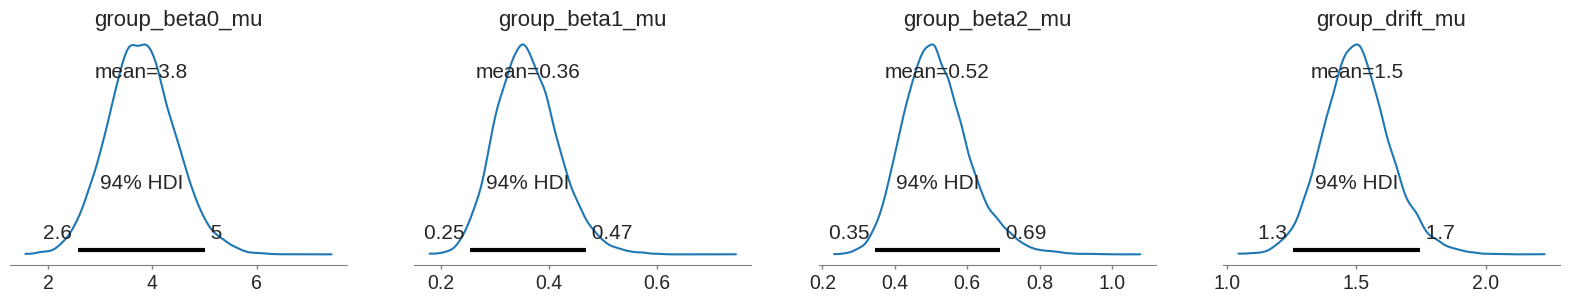

In [17]:
az.plot_posterior(
    idata_wald,
    var_names=["group_beta0_mu","group_beta1_mu","group_beta2_mu","group_drift_mu"],
    figsize=(20, 3),
);

##### Save group-level fitted parameters

In [18]:
df_beta0_mu = wald_fitting_summary.loc[f'group_beta0_mu']
df_beta0_sigma = wald_fitting_summary.loc[f'group_beta0_sigma']

df_beta1_mu = wald_fitting_summary.loc[f'group_beta1_mu']
df_beta1_sigma = wald_fitting_summary.loc[f'group_beta1_sigma']

df_beta2_mu = wald_fitting_summary.loc[f'group_beta2_mu']
df_beta2_sigma = wald_fitting_summary.loc[f'group_beta2_sigma']

df_beta2_mu = wald_fitting_summary.loc[f'group_beta2_mu']
df_beta2_sigma = wald_fitting_summary.loc[f'group_beta2_sigma']

df_drift_mu = wald_fitting_summary.loc[f'group_drift_mu']
df_drift_sigma = wald_fitting_summary.loc[f'group_drift_sigma']


df_log_beta0_mu = wald_fitting_summary.loc[f'group_log_beta0_mu']
df_log_beta0_sigma = wald_fitting_summary.loc[f'group_log_beta0_sigma']

df_log_beta1_mu = wald_fitting_summary.loc[f'group_log_beta1_mu']
df_log_beta1_sigma = wald_fitting_summary.loc[f'group_log_beta1_sigma']

df_log_beta2_mu = wald_fitting_summary.loc[f'group_log_beta2_mu']
df_log_beta2_sigma = wald_fitting_summary.loc[f'group_log_beta2_sigma']

df_log_beta2_mu = wald_fitting_summary.loc[f'group_log_beta2_mu']
df_log_beta2_sigma = wald_fitting_summary.loc[f'group_log_beta2_sigma']

df_log_drift_mu = wald_fitting_summary.loc[f'group_log_drift_mu']
df_log_drift_sigma = wald_fitting_summary.loc[f'group_log_drift_sigma']


row = {'group_beta0_mu_mean': df_beta0_mu['mean'],
       'group_beta0_mu_sd': df_beta0_mu['sd'],
       'group_beta0_mu_hdi_3%': df_beta0_mu['hdi_3%'],
       'group_beta0_mu_hdi_97%': df_beta0_mu['hdi_97%'],
       'group_beta0_mu_r_hat': df_beta0_mu['r_hat'],
       
       'group_beta0_sigma_mean': df_beta0_sigma['mean'],
       'group_beta0_sigma_sd': df_beta0_sigma['sd'],
       'group_beta0_sigma_hdi_3%': df_beta0_sigma['hdi_3%'],
       'group_beta0_sigma_hdi_97%': df_beta0_sigma['hdi_97%'],
       'group_beta0_sigma_r_hat': df_beta0_sigma['r_hat'],

       'group_beta1_mu_mean': df_beta1_mu['mean'],
       'group_beta1_mu_sd': df_beta1_mu['sd'],
       'group_beta1_mu_hdi_3%': df_beta1_mu['hdi_3%'],
       'group_beta1_mu_hdi_97%': df_beta1_mu['hdi_97%'],
       'group_beta1_mu_r_hat': df_beta1_mu['r_hat'],
       
       'group_beta1_sigma_mean': df_beta1_sigma['mean'],
       'group_beta1_sigma_sd': df_beta1_sigma['sd'],
       'group_beta1_sigma_hdi_3%': df_beta1_sigma['hdi_3%'],
       'group_beta1_sigma_hdi_97%': df_beta1_sigma['hdi_97%'],
       'group_beta1_sigma_r_hat': df_beta1_sigma['r_hat'],

       'group_beta2_mu_mean': df_beta2_mu['mean'],
       'group_beta2_mu_sd': df_beta2_mu['sd'],
       'group_beta2_mu_hdi_3%': df_beta2_mu['hdi_3%'],
       'group_beta2_mu_hdi_97%': df_beta2_mu['hdi_97%'],
       'group_beta2_mu_r_hat': df_beta2_mu['r_hat'],
       
       'group_beta2_sigma_mean': df_beta2_sigma['mean'],
       'group_beta2_sigma_sd': df_beta2_sigma['sd'],
       'group_beta2_sigma_hdi_3%': df_beta2_sigma['hdi_3%'],
       'group_beta2_sigma_hdi_97%': df_beta2_sigma['hdi_97%'],
       'group_beta2_sigma_r_hat': df_beta2_sigma['r_hat'],

       'group_drift_mu_mean': df_drift_mu['mean'],
       'group_drift_mu_sd': df_drift_mu['sd'],
       'group_drift_mu_hdi_3%': df_drift_mu['hdi_3%'],
       'group_drift_mu_hdi_97%': df_drift_mu['hdi_97%'],
       'group_drift_mu_r_hat': df_drift_mu['r_hat'],
       
       'group_drift_sigma_mean': df_drift_sigma['mean'],
       'group_drift_sigma_sd': df_drift_sigma['sd'],
       'group_drift_sigma_hdi_3%': df_drift_sigma['hdi_3%'],
       'group_drift_sigma_hdi_97%': df_drift_sigma['hdi_97%'],
       'group_drift_sigma_r_hat': df_drift_sigma['r_hat'],

       'group_log_beta0_mu_mean': df_log_beta0_mu['mean'],
       'group_log_beta0_mu_sd': df_log_beta0_mu['sd'],
       'group_log_beta0_mu_hdi_3%': df_log_beta0_mu['hdi_3%'],
       'group_log_beta0_mu_hdi_97%': df_log_beta0_mu['hdi_97%'],
       'group_log_beta0_mu_r_hat': df_log_beta0_mu['r_hat'],
       
       'group_log_beta0_sigma_mean': df_log_beta0_sigma['mean'],
       'group_log_beta0_sigma_sd': df_log_beta0_sigma['sd'],
       'group_log_beta0_sigma_hdi_3%': df_log_beta0_sigma['hdi_3%'],
       'group_log_beta0_sigma_hdi_97%': df_log_beta0_sigma['hdi_97%'],
       'group_log_beta0_sigma_r_hat': df_log_beta0_sigma['r_hat'],

       'group_log_beta1_mu_mean': df_log_beta1_mu['mean'],
       'group_log_beta1_mu_sd': df_log_beta1_mu['sd'],
       'group_log_beta1_mu_hdi_3%': df_log_beta1_mu['hdi_3%'],
       'group_log_beta1_mu_hdi_97%': df_log_beta1_mu['hdi_97%'],
       'group_log_beta1_mu_r_hat': df_log_beta1_mu['r_hat'],
       
       'group_log_beta1_sigma_mean': df_log_beta1_sigma['mean'],
       'group_log_beta1_sigma_sd': df_log_beta1_sigma['sd'],
       'group_log_beta1_sigma_hdi_3%': df_log_beta1_sigma['hdi_3%'],
       'group_log_beta1_sigma_hdi_97%': df_log_beta1_sigma['hdi_97%'],
       'group_log_beta1_sigma_r_hat': df_log_beta1_sigma['r_hat'],

       'group_log_beta2_mu_mean': df_log_beta2_mu['mean'],
       'group_log_beta2_mu_sd': df_log_beta2_mu['sd'],
       'group_log_beta2_mu_hdi_3%': df_log_beta2_mu['hdi_3%'],
       'group_log_beta2_mu_hdi_97%': df_log_beta2_mu['hdi_97%'],
       'group_log_beta2_mu_r_hat': df_log_beta2_mu['r_hat'],
       
       'group_log_beta2_sigma_mean': df_log_beta2_sigma['mean'],
       'group_log_beta2_sigma_sd': df_log_beta2_sigma['sd'],
       'group_log_beta2_sigma_hdi_3%': df_log_beta2_sigma['hdi_3%'],
       'group_log_beta2_sigma_hdi_97%': df_log_beta2_sigma['hdi_97%'],
       'group_log_beta2_sigma_r_hat': df_log_beta2_sigma['r_hat'],

       'group_log_drift_mu_mean': df_log_drift_mu['mean'],
       'group_log_drift_mu_sd': df_log_drift_mu['sd'],
       'group_log_drift_mu_hdi_3%': df_log_drift_mu['hdi_3%'],
       'group_log_drift_mu_hdi_97%': df_log_drift_mu['hdi_97%'],
       'group_log_drift_mu_r_hat': df_log_drift_mu['r_hat'],
       
       'group_log_drift_sigma_mean': df_log_drift_sigma['mean'],
       'group_log_drift_sigma_sd': df_log_drift_sigma['sd'],
       'group_log_drift_sigma_hdi_3%': df_log_drift_sigma['hdi_3%'],
       'group_log_drift_sigma_hdi_97%': df_log_drift_sigma['hdi_97%'],
       'group_log_drift_sigma_r_hat': df_log_drift_sigma['r_hat'],
    }

df_groups = pd.DataFrame([row])

# make sure the folder exists
outdir = "fitted_parameters/wald"
os.makedirs(outdir, exist_ok=True)

# save to CSV
out_path = os.path.join(outdir, f"group_fitted_params_wald_{wald_prior_class}.csv")
df_groups.to_csv(out_path, index=False)

### Posterior Predictive Check

In [23]:


plt.figure(figsize=(5, 3.75))

az.plot_ppc(ppc_wald, num_pp_samples=500)
plt.legend(frameon=False, fontsize=12)
sns.despine(top=True, right=True)

sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})

plt.xlabel("Reproduced time (s)", fontsize=14)
plt.ylabel("Density", fontsize=14)


# make sure the folder exists
outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, f"ppc_wald_{wald_prior_class}.svg")
plt.savefig(out_figure_path, dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 500x375 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Save model graph

In [51]:
import re
g = pm.model_to_graphviz(h_wald)


g.node("group_log_beta0_mu", label='<<i>μ</i><sub><i>β₀</i></sub>>')
g.node("group_log_beta0_sigma", label='<<i>σ</i><sub><i>β₀</i></sub>>')
g.node("group_log_beta1_mu", label='<<i>μ</i><sub><i>β₁</i></sub>>')
g.node("group_log_beta1_sigma", label='<<i>σ</i><sub><i>β₁</i></sub>>')
g.node("group_log_beta2_mu", label='<<i>μ</i><sub><i>β₂</i></sub>>')
g.node("group_log_beta2_sigma", label='<<i>σ</i><sub><i>β₂</i></sub>>')
g.node("group_log_drift_mu",label='<<i>μ</i><sub><i>v</i></sub>>')
g.node("group_log_drift_sigma",label='<<i>σ</i><sub><i>v</i></sub>>')    

g.node("indi_log_beta0", label='<log(<i>β</i><sub>0</sub><sup><i>i</i></sup>)>')
g.node("indi_log_beta1", label='<log(<i>β</i><sub>1</sub><sup><i>i</i></sup>)>')
g.node("indi_log_beta2", label='<log(<i>β</i><sub>2</sub><sup><i>i</i></sup>)>')
g.node("indi_log_drift", label='<log(<i>v</i><sup><i>i</i></sup>)>')

g.node("indi_beta0", label='<<i>β</i><sub>0</sub><sup><i>i</i></sup>>')
g.node("indi_beta1", label='<<i>β</i><sub>1</sub><sup><i>i</i></sup>>')
g.node("indi_beta2", label='<<i>β</i><sub>2</sub><sup><i>i</i></sup>>')
g.node("indi_drift", label='<<i>v</i><sup><i>i</i></sup>>')

g.node("subj_idx", label='<<font>Subject idx </font><i>i</i>>')
g.node("wt", label='<WT<sub>t</sub><sup>i</sup>>')
g.node("rt", label='<RT<sub>t</sub><sup>i</sup>>')

g.node("alpha_n", label='<α<sub>t</sub><sup>i</sup>>')

g.node("reproduced_times", label='<<font>ReproT</font><sub>t</sub><sup>i</sup>>')

g.graph_attr.update(
    rankdir="LR", 
)



g.render(f"../figures/wald_graph_{wald_prior_class}", format="pdf", cleanup=True)  

'../figures/wald_graph_log_normal_prior_centered.pdf'

#### Fraction of participants eith beta_1 < beta_2 reliably

In [11]:
import xarray as xr
import numpy as np

post = idata_wald.posterior

# 1) Posterior for the difference (beta1 - beta2) for each subject
diff = post["indi_beta1"] - post["indi_beta2"]   # dims: chain, draw, subject

# 2) Probability that (beta1 - beta2) < 0 for each subject
prob_below_zero = (diff < 0).mean(dim=("chain", "draw"))
# prob_below_zero is a DataArray with dim "subject"

print(prob_below_zero)

# Boolean mask
mask = prob_below_zero > 0.99

# Subjects that satisfy the criterion
subjects_high_prob = prob_below_zero["subject"].values[mask.values]
probs_high_prob    = prob_below_zero.values[mask.values]

for s, p in zip(subjects_high_prob, probs_high_prob):
    print(f"subject {s}: P(indi_beta1 - indi_beta2 < 0) = {p:.3f}")



<xarray.DataArray (subject: 21)> Size: 168B
array([0.99925  , 0.0725   , 0.8468125, 1.       , 0.172375 , 0.9999375,
       1.       , 0.992625 , 0.8028125, 0.9955   , 0.4165625, 0.9985   ,
       0.1449375, 0.0045   , 0.910875 , 0.4165   , 0.9999375, 0.8325625,
       0.9966875, 0.0610625, 0.464125 ])
Coordinates:
  * subject  (subject) int64 168B 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 20 21 22 23
subject 1: P(indi_beta1 - indi_beta2 < 0) = 0.999
subject 4: P(indi_beta1 - indi_beta2 < 0) = 1.000
subject 6: P(indi_beta1 - indi_beta2 < 0) = 1.000
subject 7: P(indi_beta1 - indi_beta2 < 0) = 1.000
subject 8: P(indi_beta1 - indi_beta2 < 0) = 0.993
subject 10: P(indi_beta1 - indi_beta2 < 0) = 0.996
subject 12: P(indi_beta1 - indi_beta2 < 0) = 0.999
subject 18: P(indi_beta1 - indi_beta2 < 0) = 1.000
subject 21: P(indi_beta1 - indi_beta2 < 0) = 0.997


## Fit Wald-model with no distinction between RT and IT (simple)

In [26]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}


if wald_prior_class in ["log_normal_prior_non_centered","log_normal_prior_centered"]:
    
    with pm.Model(coords=coords) as h_wald_simple:
        # ----- data  -----
        tt_dat   = pm.Data("tt", tt, dims="obs")
        subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")
    
        # ===== group-level priors on log scale =====
    
        group_log_beta0_mu, group_log_beta0_sigma = pm.Normal("group_log_beta0_mu", 0, 0.5), pm.HalfNormal("group_log_beta0_sigma", 0.5)
        group_log_beta_t_mu, group_log_beta_t_sigma = pm.Normal("group_log_beta_t_mu", 0, 0.5), pm.HalfNormal("group_log_beta_t_sigma", 0.5)
    
        group_log_drift_mu    = pm.Normal("group_log_drift_mu", 0.5, 0.5)
        group_log_drift_sigma = pm.HalfNormal("group_log_drift_sigma", 0.5)

        if wald_prior_class == "log_normal_prior_centered":    
    
            # ===== individual-level parameters  =====
            indi_log_beta0 = pm.Normal("indi_log_beta0", mu=group_log_beta0_mu, sigma=group_log_beta0_sigma, dims="subject")
            indi_log_beta_t = pm.Normal("indi_log_beta_t", mu=group_log_beta_t_mu, sigma=group_log_beta_t_sigma, dims="subject")
            indi_log_drift = pm.Normal("indi_log_drift", mu=group_log_drift_mu, sigma=group_log_drift_sigma, dims="subject")

        elif wald_prior_class == "log_normal_prior_non_centered":   
            # ===== subject-level parameters (NON-CENTERED) =====
            z_b0 = pm.Normal("z_b0", 0.0, 1.0, dims="subject")
            z_b1 = pm.Normal("z_b1", 0.0, 1.0, dims="subject")
            z_d  = pm.Normal("z_drift", 0.0, 1.0, dims="subject")
        
            indi_log_beta0 = pm.Deterministic("indi_log_beta0", group_log_beta0_mu + group_log_beta0_sigma * z_b0, dims="subject")
            indi_log_beta_t = pm.Deterministic("indi_log_beta_t", group_log_beta_t_mu + group_log_beta_t_sigma * z_b1, dims="subject")
            indi_log_drift = pm.Deterministic("indi_log_drift", group_log_drift_mu + group_log_drift_sigma * z_d,  dims="subject")
        
        indi_beta0 = pm.Deterministic("indi_beta0", pt.exp(indi_log_beta0), dims="subject")
        indi_beta_t = pm.Deterministic("indi_beta_t", pt.exp(indi_log_beta_t), dims="subject")
        indi_drift = pm.Deterministic("indi_drift", pt.exp(indi_log_drift), dims="subject")
            
    
        # ===== trial-level link =====
        i = pm.intX(subj_dat)  # map each trial to its subject
        
        alpha_n   = pm.Deterministic(
            "alpha_n",
            indi_beta0[i] + indi_beta_t[i]*tt_dat,
            dims="obs"
        )
    
        mu_n  = alpha_n / (indi_drift[i] + 1e-9) 
        lam_n = alpha_n**2
    
        pm.Wald("reproduced_times", mu=mu_n, lam=lam_n, alpha = fixed_ndt, observed=rep, dims="obs")
        
        # ===== sampling =====
        idata_wald_simple = pm.sample(
            draws=num_draws,
            tune=num_tune,
            target_accept=targ_accept,
            chains=4,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )
        ppc_wald_simple = pm.sample_posterior_predictive(idata_wald_simple, var_names=["reproduced_times","alpha_n"])
    
    post = idata_wald_simple.posterior
    idata_wald_simple.posterior = post.assign(
        group_beta0_mu = np.exp(post["group_log_beta0_mu"]),
        group_beta_t_mu = np.exp(post["group_log_beta_t_mu"]),
        group_drift_mu = np.exp(post["group_log_drift_mu"]),
    
        # on original scale these are geometric SDs
        group_beta0_sigma = np.exp(post["group_log_beta0_sigma"]),
        group_beta_t_sigma = np.exp(post["group_log_beta_t_sigma"]),
        group_drift_sigma = np.exp(post["group_log_drift_sigma"]),
    )
    
    wald_fitting_summary = az.summary(idata_wald_simple)
    


In [9]:
az.to_netcdf(idata_wald_simple, f"idata_wald_simple_{wald_prior_class}.nc")     

'idata_wald_simple_log_normal_prior_centered.nc'

In [27]:
with h_wald_simple:
    prior_pred_wald_simple = pm.sample_prior_predictive(500, var_names=["reproduced_times","alpha_n"])  

y_prior_wald_simple = prior_pred_wald_simple.prior_predictive["reproduced_times"].values.ravel()

Sampling: [group_log_beta0_mu, group_log_beta0_sigma, group_log_beta_t_mu, group_log_beta_t_sigma, group_log_drift_mu, group_log_drift_sigma, indi_log_beta0, indi_log_beta_t, indi_log_drift, reproduced_times]


## Fit regression model 

In [28]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}

with pm.Model(coords=coords) as h_reg:
    # Data
    rt_dat   = pm.Data("rt", rt, dims="obs")
    wt_dat   = pm.Data("wt", wt, dims="obs")
    subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")
    y_dat    = pm.Data("rep", rep, dims="obs")

    # Group-level priors (log scale)
    log_beta0_mu, log_beta0_sigma = pm.Normal("log_beta0_mu", -0.5, 0.5), pm.HalfNormal("log_beta0_sigma", 0.5)
    log_beta1_mu, log_beta1_sigma = pm.Normal("log_beta1_mu", -0.5, 0.5), pm.HalfNormal("log_beta1_sigma", 0.5)
    log_beta2_mu, log_beta2_sigma = pm.Normal("log_beta2_mu", -0.5, 0.5), pm.HalfNormal("log_beta2_sigma", 0.5)

    log_sigma_mu    = pm.Normal("log_sigma_mu", -0.5, 0.5)
    log_sigma_sigma = pm.HalfNormal("log_sigma_sigma", 0.5)

    # Subject-level (CENTERED)
    log_beta0 = pm.Normal("log_beta0", mu=log_beta0_mu, sigma=log_beta0_sigma, dims="subject")
    log_beta1 = pm.Normal("log_beta1", mu=log_beta1_mu, sigma=log_beta1_sigma, dims="subject")
    log_beta2 = pm.Normal("log_beta2", mu=log_beta2_mu, sigma=log_beta2_sigma, dims="subject")


    beta0 = pm.Deterministic("beta0", pt.exp(log_beta0), dims="subject")
    beta1 = pm.Deterministic("beta1", pt.exp(log_beta1), dims="subject")
    beta2 = pm.Deterministic("beta2", pt.exp(log_beta2), dims="subject")

    log_sigma = pm.Normal("log_sigma", mu=log_sigma_mu, sigma=log_sigma_sigma, dims="subject")
    sigma = pm.Deterministic("sigma_subj", pt.exp(log_sigma), dims="subject")

    # Likelihood
    i   = pm.intX(subj_dat)
    mu_n = beta0[i] + beta1[i] * rt_dat + beta2[i] * wt_dat
    pm.Normal("reproduced_times", mu=mu_n, sigma=sigma[i], observed=y_dat, dims="obs")

    # Sampling
    idata_reg = pm.sample(draws=num_draws, tune=num_tune, target_accept=targ_accept,
                          chains=4, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})
    ppc_reg = pm.sample_posterior_predictive(idata_reg, var_names=["reproduced_times"])

post = idata_reg.posterior
idata_reg.posterior = post.assign(
    beta0_mu = np.exp(post["log_beta0_mu"]),
    beta1_mu = np.exp(post["log_beta1_mu"]),
    beta2_mu = np.exp(post["log_beta2_mu"]),
    sigma_mu = np.exp(post["log_sigma_mu"]),

    # on original scale these are geometric SDs
    beta0_sigma = np.exp(post["log_beta0_sigma"]),
    beta1_sigma = np.exp(post["log_beta1_sigma"]),
    beta2_sigma = np.exp(post["log_beta2_sigma"]),
    sigma_sigma = np.exp(post["log_sigma_sigma"]),
)

reg_fitting_summary = az.summary(idata_reg)



'\n    # Sampling\n    idata_reg = pm.sample(draws=num_draws, tune=num_tune, target_accept=targ_accept,\n                          chains=4, return_inferencedata=True,\n                          idata_kwargs={"log_likelihood": True})\n    ppc_reg = pm.sample_posterior_predictive(idata_reg, var_names=["reproduced_times"])\n\npost = idata_reg.posterior\nidata_reg.posterior = post.assign(\n    beta0_mu = np.exp(post["log_beta0_mu"]),\n    beta1_mu = np.exp(post["log_beta1_mu"]),\n    beta2_mu = np.exp(post["log_beta2_mu"]),\n    sigma_mu = np.exp(post["log_sigma_mu"]),\n\n    # on original scale these are geometric SDs\n    beta0_sigma = np.exp(post["log_beta0_sigma"]),\n    beta1_sigma = np.exp(post["log_beta1_sigma"]),\n    beta2_sigma = np.exp(post["log_beta2_sigma"]),\n    sigma_sigma = np.exp(post["log_sigma_sigma"]),\n)\n\nreg_fitting_summary = az.summary(idata_reg)\n'

In [18]:
az.to_netcdf(idata_reg, "idata_reg.nc") 

'idata_reg.nc'

#### Prior Predictive Check

In [29]:
with h_reg:
    prior_pred_reg = pm.sample_prior_predictive(500, var_names=["reproduced_times"])  
y_prior_reg = prior_pred_reg.prior_predictive["reproduced_times"].values.ravel()

Sampling: [log_beta0, log_beta0_mu, log_beta0_sigma, log_beta1, log_beta1_mu, log_beta1_sigma, log_beta2, log_beta2_mu, log_beta2_sigma, log_sigma, log_sigma_mu, log_sigma_sigma, reproduced_times]


## Fit simple regression model 

In [32]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}

with pm.Model(coords=coords) as h_reg_simple:
    # Data
    tt_dat   = pm.Data("tt", tt, dims="obs")
    subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")
    y_dat    = pm.Data("rep", rep, dims="obs")

    # Group-level priors (log scale)
    log_beta0_mu, log_beta0_sigma = pm.Normal("log_beta0_mu", -0.5, 0.5), pm.HalfNormal("log_beta0_sigma", 0.5)
    log_beta_t_mu, log_beta_t_sigma = pm.Normal("log_beta_t_mu", -0.5, 0.5), pm.HalfNormal("log_beta_t_sigma", 0.5)

    log_sigma_mu    = pm.Normal("log_sigma_mu", -0.5, 0.5)
    log_sigma_sigma = pm.HalfNormal("log_sigma_sigma", 0.5)

    # Subject-level (CENTERED)
    log_beta0 = pm.Normal("log_beta0", mu=log_beta0_mu, sigma=log_beta0_sigma, dims="subject")
    log_beta_t = pm.Normal("log_beta_t", mu=log_beta_t_mu, sigma=log_beta_t_sigma, dims="subject")


    beta0 = pm.Deterministic("beta0", pt.exp(log_beta0), dims="subject")
    beta_t = pm.Deterministic("beta_t", pt.exp(log_beta_t), dims="subject")

    log_sigma = pm.Normal("log_sigma", mu=log_sigma_mu, sigma=log_sigma_sigma, dims="subject")
    sigma = pm.Deterministic("sigma_subj", pt.exp(log_sigma), dims="subject")

    # Likelihood
    i   = pm.intX(subj_dat)
    mu_n = beta0[i] + beta_t[i] * tt_dat
    pm.Normal("reproduced_times", mu=mu_n, sigma=sigma[i], observed=y_dat, dims="obs")

    # Sampling
    idata_reg_simple = pm.sample(draws=num_draws, tune=num_tune, target_accept=targ_accept,
                          chains=4, return_inferencedata=True,
                          idata_kwargs={"log_likelihood": True})
    ppc_reg = pm.sample_posterior_predictive(idata_reg_simple, var_names=["reproduced_times"])

post = idata_reg_simple.posterior
idata_reg_simple.posterior = post.assign(
    beta0_mu = np.exp(post["log_beta0_mu"]),
    beta_t =_mu = np.exp(post["log_beta_t_mu"]),
    sigma_mu = np.exp(post["log_sigma_mu"]),

    # on original scale these are geometric SDs
    beta0_sigma = np.exp(post["log_beta0_sigma"]),
    beta_t_sigma = np.exp(post["log_beta_t_sigma"]),
    sigma_sigma = np.exp(post["log_sigma_sigma"]),
)

reg_fitting_summary = az.summary(idata_reg_simple)



'\n    # Sampling\n    idata_reg_simple = pm.sample(draws=num_draws, tune=num_tune, target_accept=targ_accept,\n                          chains=4, return_inferencedata=True,\n                          idata_kwargs={"log_likelihood": True})\n    ppc_reg = pm.sample_posterior_predictive(idata_reg_simple, var_names=["reproduced_times"])\n\npost = idata_reg_simple.posterior\nidata_reg_simple.posterior = post.assign(\n    beta0_mu = np.exp(post["log_beta0_mu"]),\n    beta_t =_mu = np.exp(post["log_beta_t_mu"]),\n    sigma_mu = np.exp(post["log_sigma_mu"]),\n\n    # on original scale these are geometric SDs\n    beta0_sigma = np.exp(post["log_beta0_sigma"]),\n    beta_t_sigma = np.exp(post["log_beta_t_sigma"]),\n    sigma_sigma = np.exp(post["log_sigma_sigma"]),\n)\n\nreg_fitting_summary = az.summary(idata_reg_simple)\n'

In [20]:
az.to_netcdf(idata_reg_simple, "idata_reg_simple.nc") 

'idata_reg_simple.nc'

In [33]:
with h_reg_simple:
    prior_pred_reg_simple = pm.sample_prior_predictive(500, var_names=["reproduced_times"]) 

y_prior_reg_simple = prior_pred_reg_simple.prior_predictive["reproduced_times"].values.ravel()

Sampling: [log_beta0, log_beta0_mu, log_beta0_sigma, log_beta_t, log_beta_t_mu, log_beta_t_sigma, log_sigma, log_sigma_mu, log_sigma_sigma, reproduced_times]


### Prior Predictive Check

In [49]:
with h_reg:
    prior_pred_reg = pm.sample_prior_predictive(500, var_names=["reproduced_times"])  

Sampling: [log_beta1, log_beta1_mu, log_beta1_sigma, log_beta2, log_beta2_mu, log_beta2_sigma, log_sigma, log_sigma_mu, log_sigma_sigma, log_t0, log_t0_mu, log_t0_sigma, reproduced_times]


### Fitted individual-level parameter results

##### Visualize fitted params

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (84) in plot_posterior, generating only 40 plots
  warnings.warn(


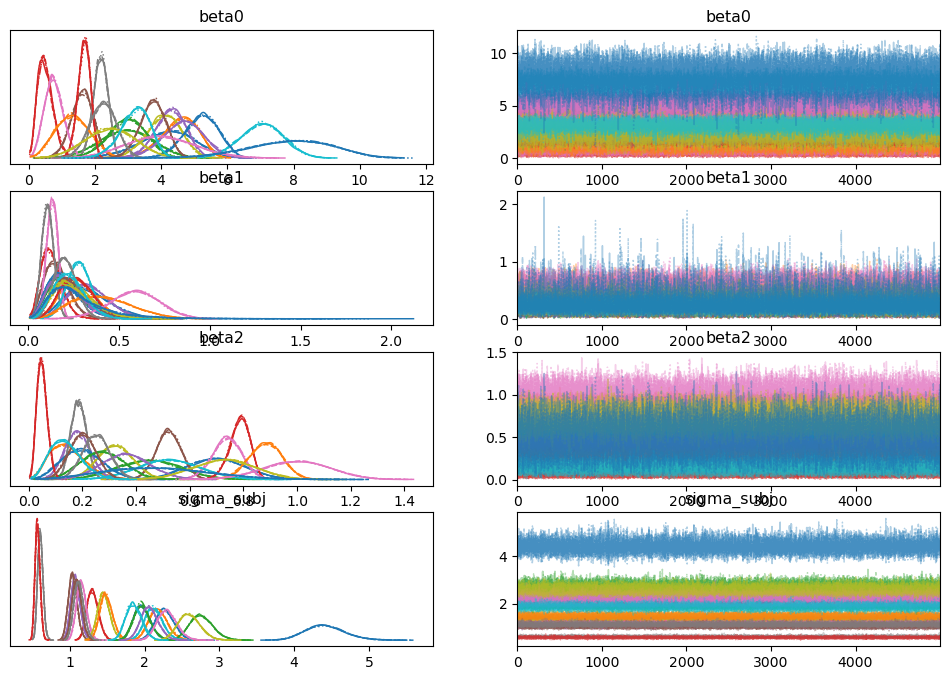

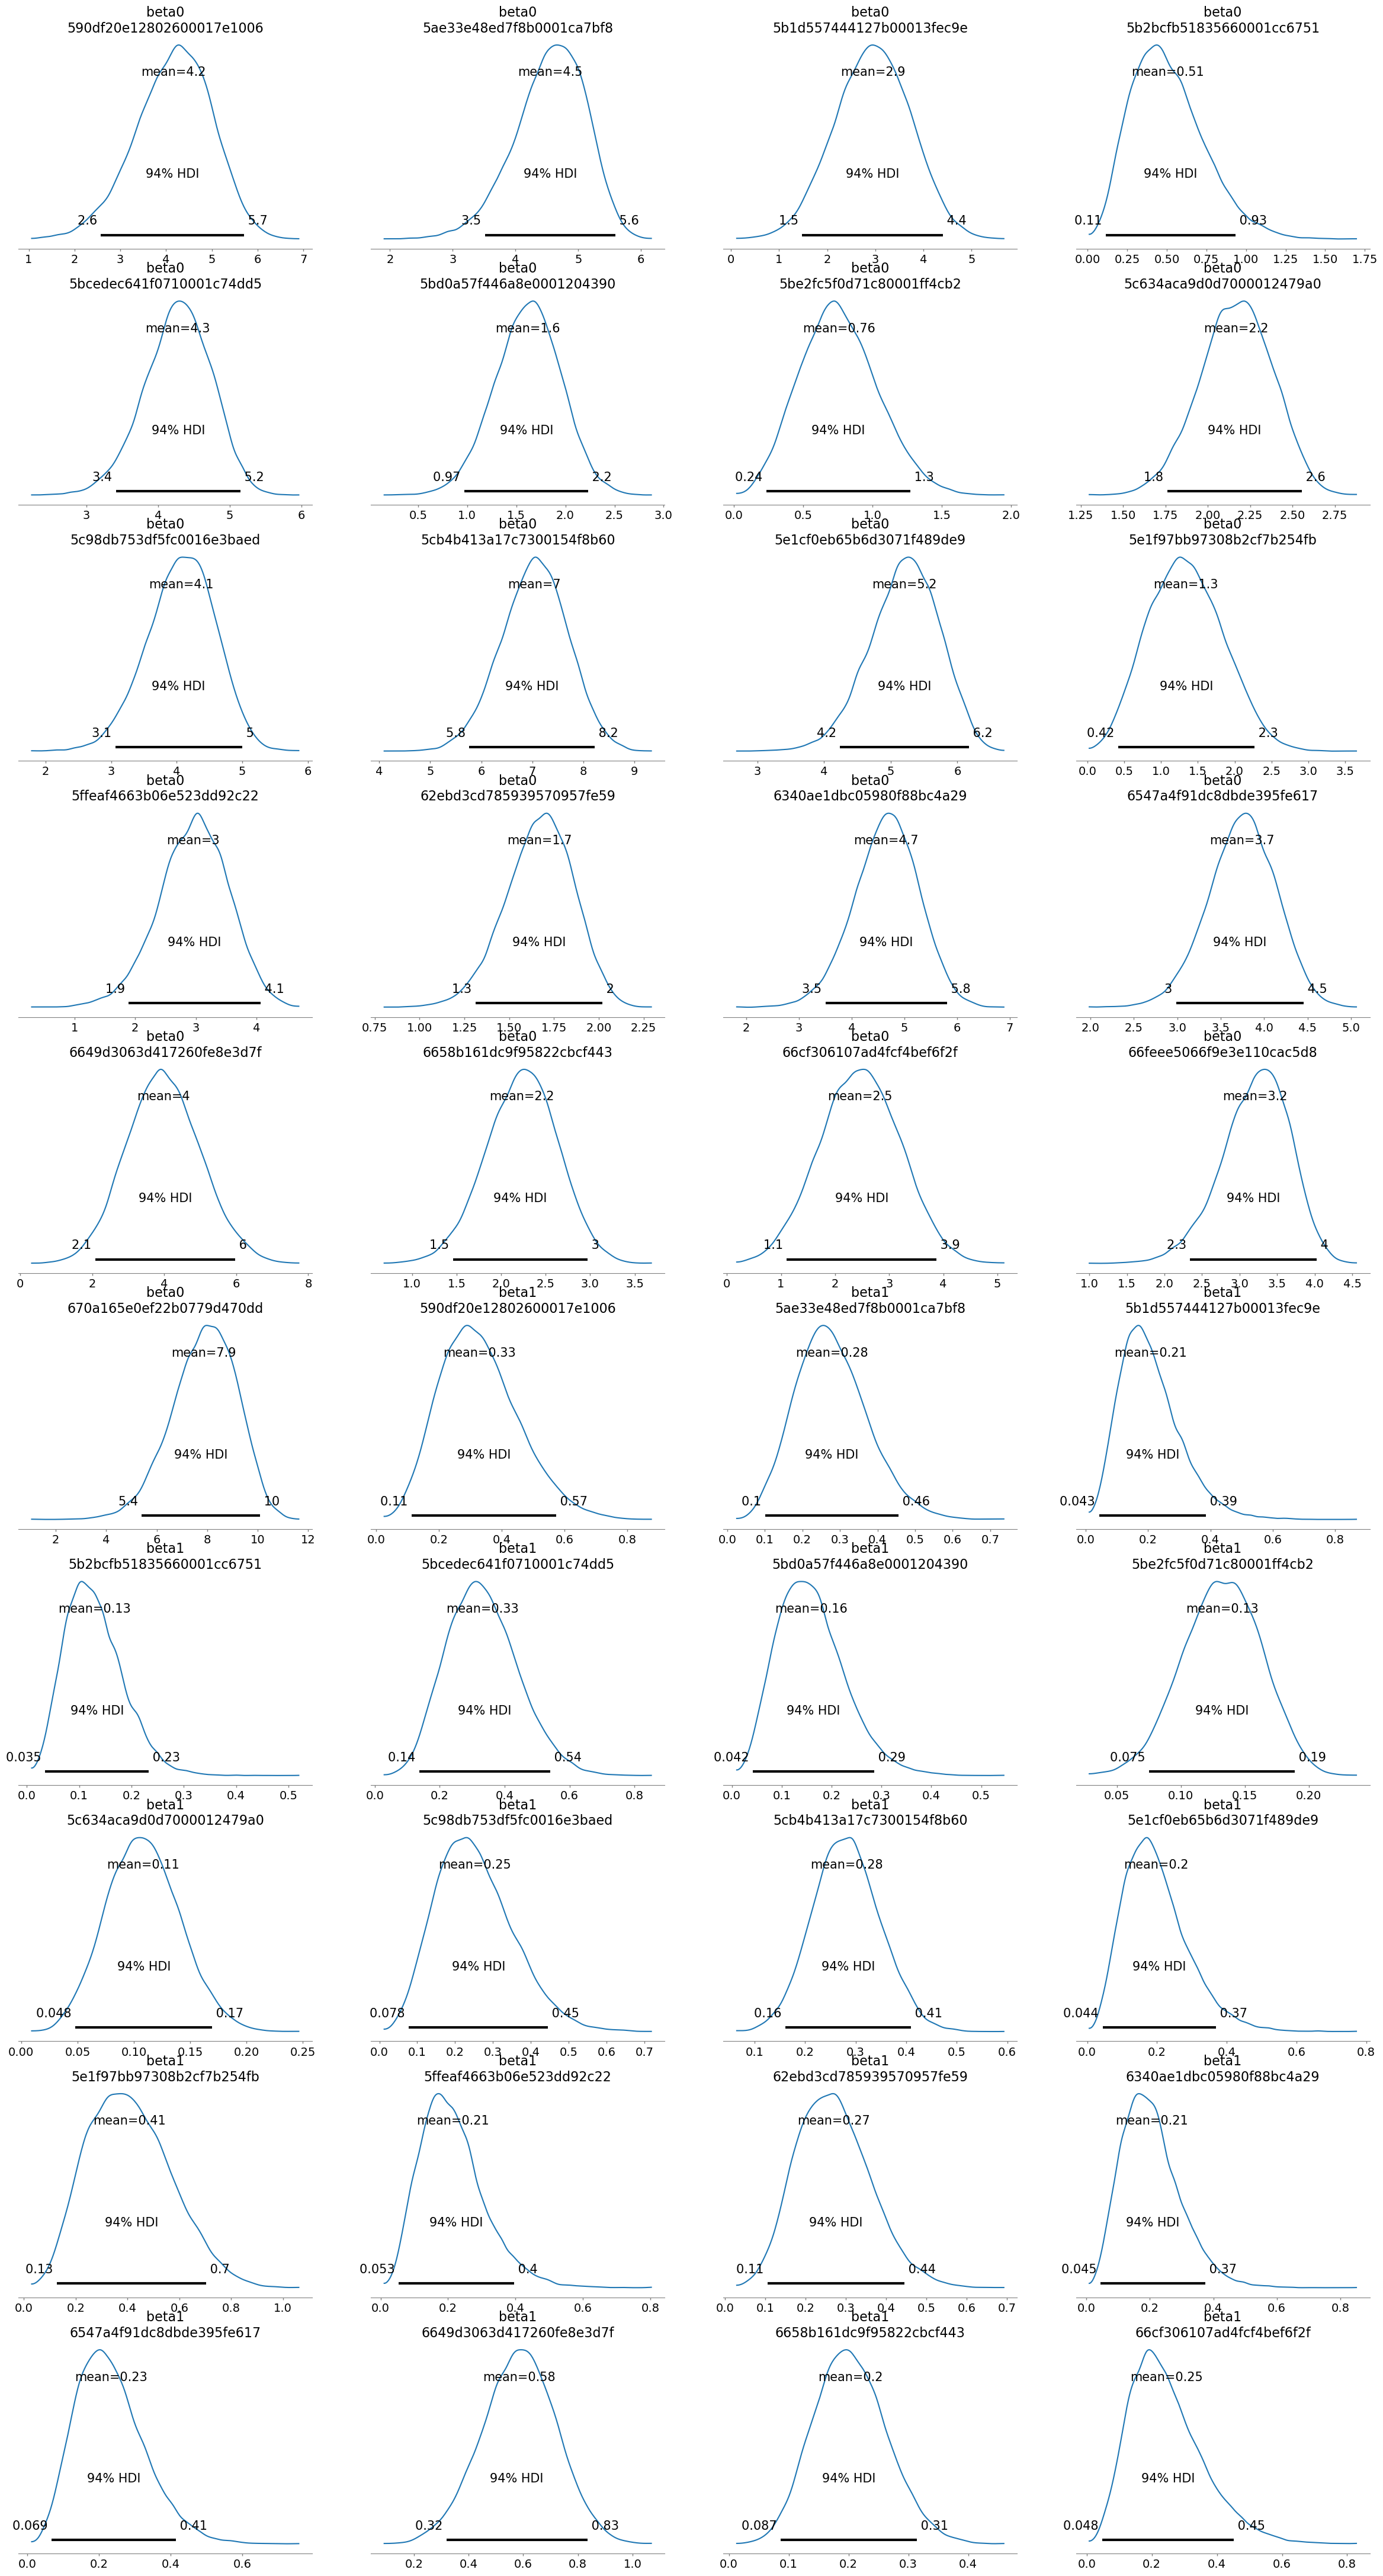

In [40]:
az.plot_trace(idata_reg, var_names=["beta0","beta1","beta2","sigma_subj"]);
az.plot_posterior(idata_reg, var_names=["beta0","beta1","beta2", "sigma_subj"]);

##### Save individual-level fitted parameters

In [41]:
rows = []

for par in par_ids:
    
    df_row_beta0 = reg_fitting_summary.loc[f'beta0[{par}]']
    df_row_beta1 = reg_fitting_summary.loc[f'beta1[{par}]']
    df_row_beta2 = reg_fitting_summary.loc[f'beta2[{par}]']
    df_row_sigma = reg_fitting_summary.loc[f'sigma_subj[{par}]']

    rows.append({
        'Participant_ID': par,
        
        'beta0_mean': df_row_beta0['mean'],
        'beta0_sd': df_row_beta0['sd'],
        'beta0_hdi_3%': df_row_beta0['hdi_3%'],
        'beta0_hdi_97%': df_row_beta0['hdi_97%'],
        'beta0_r_hat': df_row_beta0['r_hat'],
        
        'beta1_mean': df_row_beta1['mean'],
        'beta1_sd': df_row_beta1['sd'],
        'beta1_hdi_3%': df_row_beta1['hdi_3%'],
        'beta1_hdi_97%': df_row_beta1['hdi_97%'],
        'beta1_r_hat': df_row_beta1['r_hat'],

        'beta2_mean': df_row_beta2['mean'],
        'beta2_sd': df_row_beta2['sd'],
        'beta2_hdi_3%': df_row_beta2['hdi_3%'],
        'beta2_hdi_97%': df_row_beta2['hdi_97%'],
        'beta2_r_hat': df_row_beta2['r_hat'],

        'sigma_mean': df_row_sigma['mean'],
        'sigma_sd': df_row_sigma['sd'],
        'sigma_hdi_3%': df_row_sigma['hdi_3%'],
        'sigma_hdi_97%': df_row_sigma['hdi_97%'],
        'sigma_r_hat': df_row_sigma['r_hat']
    })

df_subj_reg = pd.DataFrame(rows)

# make sure the folder exists
outdir = "fitted_parameters/reg"
os.makedirs(outdir, exist_ok=True)

# save to CSV
out_path = os.path.join(outdir, "indi_fitted_params_reg.csv")
df_subj_reg.to_csv(out_path, index=False)

### Fitted group-level parameter results

##### Visualize fitted params

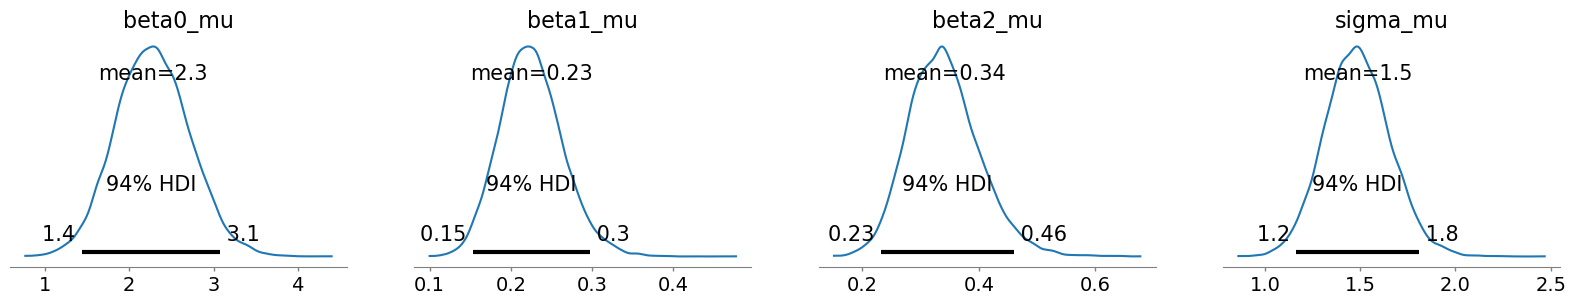

In [42]:
az.plot_posterior(
    idata_reg,
    var_names=["beta0_mu","beta1_mu","beta2_mu","sigma_mu"],
    figsize=(20, 3),
);

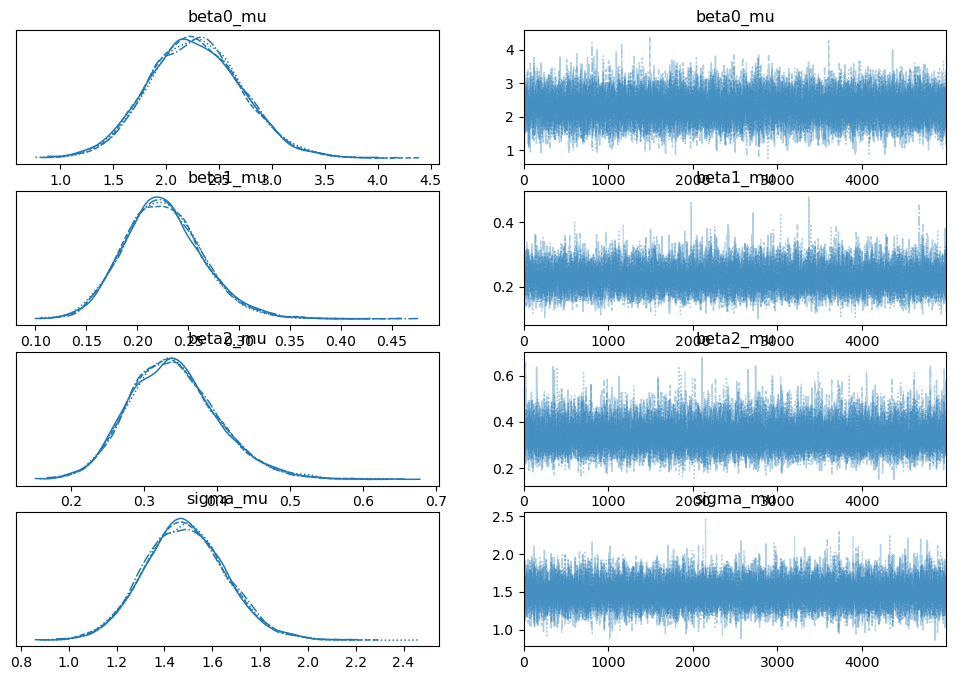

In [43]:
az.plot_trace(
    idata_reg,
    var_names=["beta0_mu","beta1_mu","beta2_mu","sigma_mu"],
);

##### Save group-level fitted parameters

In [44]:
df_beta0_mu = reg_fitting_summary.loc[f'beta0_mu']
df_beta0_sigma = reg_fitting_summary.loc[f'beta0_sigma']

df_beta1_mu = reg_fitting_summary.loc[f'beta1_mu']
df_beta1_sigma = reg_fitting_summary.loc[f'beta1_sigma']

df_beta2_mu = reg_fitting_summary.loc[f'beta2_mu']
df_beta2_sigma = reg_fitting_summary.loc[f'beta2_sigma']

df_beta2_mu = reg_fitting_summary.loc[f'beta2_mu']
df_beta2_sigma = reg_fitting_summary.loc[f'beta2_sigma']

df_sigma_mu = reg_fitting_summary.loc[f'sigma_mu']
df_sigma_sigma = reg_fitting_summary.loc[f'sigma_sigma']


row = {'beta0_mu_mean': df_beta0_mu['mean'],
       'beta0_mu_sd': df_beta0_mu['sd'],
       'beta0_mu_hdi_3%': df_beta0_mu['hdi_3%'],
       'beta0_mu_hdi_97%': df_beta0_mu['hdi_97%'],
       'beta0_mu_r_hat': df_beta0_mu['r_hat'],
       
       'beta0_sigma_mean': df_beta0_sigma['mean'],
       'beta0_sigma_sd': df_beta0_sigma['sd'],
       'beta0_sigma_hdi_3%': df_beta0_sigma['hdi_3%'],
       'beta0_sigma_hdi_97%': df_beta0_sigma['hdi_97%'],
       'beta0_sigma_r_hat': df_beta0_sigma['r_hat'],

       'beta1_mu_mean': df_beta0_mu['mean'],
       'beta1_mu_sd': df_beta0_mu['sd'],
       'beta1_mu_hdi_3%': df_beta0_mu['hdi_3%'],
       'beta1_mu_hdi_97%': df_beta0_mu['hdi_97%'],
       'beta1_mu_r_hat': df_beta0_mu['r_hat'],
       
       'beta1_sigma_mean': df_beta1_sigma['mean'],
       'beta1_sigma_sd': df_beta1_sigma['sd'],
       'beta1_sigma_hdi_3%': df_beta1_sigma['hdi_3%'],
       'beta1_sigma_hdi_97%': df_beta1_sigma['hdi_97%'],
       'beta1_sigma_r_hat': df_beta1_sigma['r_hat'],

       'beta2_mu_mean': df_beta2_mu['mean'],
       'beta2_mu_sd': df_beta2_mu['sd'],
       'beta2_mu_hdi_3%': df_beta2_mu['hdi_3%'],
       'beta2_mu_hdi_97%': df_beta2_mu['hdi_97%'],
       'beta2_mu_r_hat': df_beta2_mu['r_hat'],
       
       'beta2_sigma_mean': df_beta2_sigma['mean'],
       'beta2_sigma_sd': df_beta2_sigma['sd'],
       'beta2_sigma_hdi_3%': df_beta2_sigma['hdi_3%'],
       'beta2_sigma_hdi_97%': df_beta2_sigma['hdi_97%'],
       'beta2_sigma_r_hat': df_beta2_sigma['r_hat'],

       'sigma_mu_mean': df_sigma_mu['mean'],
       'sigma_mu_sd': df_sigma_mu['sd'],
       'sigma_mu_hdi_3%': df_sigma_mu['hdi_3%'],
       'sigma_mu_hdi_97%': df_sigma_mu['hdi_97%'],
       'sigma_mu_r_hat': df_sigma_mu['r_hat'],
       
       'sigma_sigma_mean': df_sigma_sigma['mean'],
       'sigma_sigma_sd': df_sigma_sigma['sd'],
       'sigma_sigma_hdi_3%': df_sigma_sigma['hdi_3%'],
       'sigma_sigma_hdi_97%': df_sigma_sigma['hdi_97%'],
       'sigma_sigma_r_hat': df_sigma_sigma['r_hat'],
    }

df_groups_reg = pd.DataFrame([row])

# make sure the folder exists
outdir = "fitted_parameters/reg"
os.makedirs(outdir, exist_ok=True)

# save to CSV
out_path = os.path.join(outdir, "group_fitted_params_reg.csv")
df_groups_reg.to_csv(out_path, index=False)

### Posterior Predictive Check

In [142]:
az.plot_ppc(ppc_reg, num_pp_samples=300)

# make sure the folder exists
outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, "ppc_reg.svg")
plt.savefig(out_figure_path, dpi=300, bbox_inches='tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

### Save model graph

In [143]:
g = pm.model_to_graphviz(h_reg)
g.render("../figures/reg_graph", format="svg", cleanup=True)  

'../figures/reg_graph.svg'

## Fit log-normal distribution

In [65]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}

# Decision-time (RT minus non-decision time) as data:
# Make sure all values are > 0
rep_shifted = rep - fixed_ndt
#dec_time_np = np.maximum(rep - fixed_ndt, EPS).astype(float)

if wald_prior_class in ["log_normal_prior_non_centered", "log_normal_prior_centered"]:
    
    with pm.Model(coords=coords) as h_lognorm:
        # ----- data  -----
        rt_dat   = pm.Data("rt", rt, dims="obs")
        wt_dat   = pm.Data("wt", wt, dims="obs")
        subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")

        # ===== group-level priors on log scale =====
        # positive regression coefficients (like in your Wald model)
        group_log_beta0_mu, group_log_beta0_sigma = pm.Normal(
            "group_log_beta0_mu", 0, 0.5
        ), pm.HalfNormal("group_log_beta0_sigma", 0.5)

        group_log_beta1_mu, group_log_beta1_sigma = pm.Normal(
            "group_log_beta1_mu", 0, 0.5
        ), pm.HalfNormal("group_log_beta1_sigma", 0.5)

        group_log_beta2_mu, group_log_beta2_sigma = pm.Normal(
            "group_log_beta2_mu", 0, 0.5
        ), pm.HalfNormal("group_log_beta2_sigma", 0.5)

        # log-sigma hyperpriors for the LogNormal
        group_log_sigma_mu    = pm.Normal("group_log_sigma_mu", 0.0, 0.5)
        group_log_sigma_sigma = pm.HalfNormal("group_log_sigma_sigma", 0.5)

        # ===== individual-level parameters =====
        if wald_prior_class == "log_normal_prior_centered":    
    
            indi_log_beta0 = pm.Normal(
                "indi_log_beta0",
                mu=group_log_beta0_mu,
                sigma=group_log_beta0_sigma,
                dims="subject",
            )
            indi_log_beta1 = pm.Normal(
                "indi_log_beta1",
                mu=group_log_beta1_mu,
                sigma=group_log_beta1_sigma,
                dims="subject",
            )
            indi_log_beta2 = pm.Normal(
                "indi_log_beta2",
                mu=group_log_beta2_mu,
                sigma=group_log_beta2_sigma,
                dims="subject",
            )

            indi_log_sigma = pm.Normal(
                "indi_log_sigma",
                mu=group_log_sigma_mu,
                sigma=group_log_sigma_sigma,
                dims="subject",
            )

        elif wald_prior_class == "log_normal_prior_non_centered":
            # ===== subject-level parameters (NON-CENTERED) =====
            z_b0 = pm.Normal("z_b0", 0.0, 1.0, dims="subject")
            z_b1 = pm.Normal("z_b1", 0.0, 1.0, dims="subject")
            z_b2 = pm.Normal("z_b2", 0.0, 1.0, dims="subject")
            z_s  = pm.Normal("z_sigma", 0.0, 1.0, dims="subject")

            indi_log_beta0 = pm.Deterministic(
                "indi_log_beta0",
                group_log_beta0_mu + group_log_beta0_sigma * z_b0,
                dims="subject",
            )
            indi_log_beta1 = pm.Deterministic(
                "indi_log_beta1",
                group_log_beta1_mu + group_log_beta1_sigma * z_b1,
                dims="subject",
            )
            indi_log_beta2 = pm.Deterministic(
                "indi_log_beta2",
                group_log_beta2_mu + group_log_beta2_sigma * z_b2,
                dims="subject",
            )
            indi_log_sigma = pm.Deterministic(
                "indi_log_sigma",
                group_log_sigma_mu + group_log_sigma_sigma * z_s,
                dims="subject",
            )

        # back-transform to positive scale
        indi_beta0 = pm.Deterministic("indi_beta0", pt.exp(indi_log_beta0), dims="subject")
        indi_beta1 = pm.Deterministic("indi_beta1", pt.exp(indi_log_beta1), dims="subject")
        indi_beta2 = pm.Deterministic("indi_beta2", pt.exp(indi_log_beta2), dims="subject")
        indi_sigma = pm.Deterministic("indi_sigma", pt.exp(indi_log_sigma), dims="subject")
            
        # ===== trial-level link: mean on *log* scale of decision time =====
        i = pm.intX(subj_dat)  # map each trial to its subject
        
        alpha_n = pm.Deterministic(
            "alpha_n",
            indi_beta0[i] + indi_beta1[i] * rt_dat + indi_beta2[i] * wt_dat,
            dims="obs",
        )

        # ===== shifted log-normal likelihood =====
        # Here `rep_shifted` is RT - fixed_ndt, passed in as a pure numpy array.
        decision_time = pm.LogNormal(
            "reproduced_times",   # this is RT - fixed_ndt
            mu=alpha_n,
            sigma=indi_sigma[i],
            observed=rep_shifted,
            dims="obs",
        )

        # ===== sampling =====
        idata_lognorm = pm.sample(
            draws=num_draws,
            tune=num_tune,
            target_accept=targ_accept,
            chains=4,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )

        ppc_lognorm = pm.sample_posterior_predictive(
            idata_lognorm,
            var_names=["reproduced_times", "alpha_n"],
        )

    # ===== back-transform group-level hyperparameters =====
    post = idata_lognorm.posterior
    idata_lognorm.posterior = post.assign(
        group_beta0_mu   = np.exp(post["group_log_beta0_mu"]),
        group_beta1_mu   = np.exp(post["group_log_beta1_mu"]),
        group_beta2_mu   = np.exp(post["group_log_beta2_mu"]),
        group_sigma_mu   = np.exp(post["group_log_sigma_mu"]),

        # geometric SDs on original scales
        group_beta0_sigma = np.exp(post["group_log_beta0_sigma"]),
        group_beta1_sigma = np.exp(post["group_log_beta1_sigma"]),
        group_beta2_sigma = np.exp(post["group_log_beta2_sigma"]),
        group_sigma_sigma = np.exp(post["group_log_sigma_sigma"]),
    )

    lognorm_fitting_summary = az.summary(idata_lognorm)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_log_beta0_mu, group_log_beta0_sigma, group_log_beta1_mu, group_log_beta1_sigma, group_log_beta2_mu, group_log_beta2_sigma, group_log_sigma_mu, group_log_sigma_sigma, indi_log_beta0, indi_log_beta1, indi_log_beta2, indi_log_sigma]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 1024 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [reproduced_times]


Output()

In [66]:
az.to_netcdf(idata_lognorm, "idata_lognormal.nc") 

'idata_lognormal.nc'

## Fit log-normal distribution (simple)

In [44]:
coords = {
    "subject": par_ids, 
    "obs":     np.arange(rt.size),
}

# Decision-time (RT minus non-decision time) as data:
# Make sure all values are > 0
rep_shifted = rep - fixed_ndt
#dec_time_np = np.maximum(rep - fixed_ndt, EPS).astype(float)

if wald_prior_class in ["log_normal_prior_non_centered", "log_normal_prior_centered"]:
    
    with pm.Model(coords=coords) as h_lognorm:
        # ----- data  -----
        tt_dat   = pm.Data("tt", tt, dims="obs")
        subj_dat = pm.Data("subj_idx", subj_idx.astype(int), dims="obs")

        # ===== group-level priors on log scale =====
        # positive regression coefficients (like in your Wald model)
        group_log_beta0_mu, group_log_beta0_sigma = pm.Normal(
            "group_log_beta0_mu", 0, 0.5
        ), pm.HalfNormal("group_log_beta0_sigma", 0.5)

        group_log_beta_t_mu, group_log_beta_t_sigma = pm.Normal(
            "group_log_beta_t_mu", 0, 0.5
        ), pm.HalfNormal("group_log_beta_t_sigma", 0.5)


        # log-sigma hyperpriors for the LogNormal
        group_log_sigma_mu    = pm.Normal("group_log_sigma_mu", 0.0, 0.5)
        group_log_sigma_sigma = pm.HalfNormal("group_log_sigma_sigma", 0.5)

        # ===== individual-level parameters =====
        if wald_prior_class == "log_normal_prior_centered":    
    
            indi_log_beta0 = pm.Normal(
                "indi_log_beta0",
                mu=group_log_beta0_mu,
                sigma=group_log_beta0_sigma,
                dims="subject",
            )
            indi_log_beta_t = pm.Normal(
                "indi_log_beta_t",
                mu=group_log_beta_t_mu,
                sigma=group_log_beta_t_sigma,
                dims="subject",
            )
         
            indi_log_sigma = pm.Normal(
                "indi_log_sigma",
                mu=group_log_sigma_mu,
                sigma=group_log_sigma_sigma,
                dims="subject",
            )

        elif wald_prior_class == "log_normal_prior_non_centered":
            # ===== subject-level parameters (NON-CENTERED) =====
            z_b0 = pm.Normal("z_b0", 0.0, 1.0, dims="subject")
            z_b1 = pm.Normal("z_b1", 0.0, 1.0, dims="subject")
            z_b2 = pm.Normal("z_b2", 0.0, 1.0, dims="subject")
            z_s  = pm.Normal("z_sigma", 0.0, 1.0, dims="subject")

            indi_log_beta0 = pm.Deterministic(
                "indi_log_beta0",
                group_log_beta0_mu + group_log_beta0_sigma * z_b0,
                dims="subject",
            )
            indi_log_beta1 = pm.Deterministic(
                "indi_log_beta1",
                group_log_beta1_mu + group_log_beta1_sigma * z_b1,
                dims="subject",
            )
            indi_log_beta2 = pm.Deterministic(
                "indi_log_beta2",
                group_log_beta2_mu + group_log_beta2_sigma * z_b2,
                dims="subject",
            )
            indi_log_sigma = pm.Deterministic(
                "indi_log_sigma",
                group_log_sigma_mu + group_log_sigma_sigma * z_s,
                dims="subject",
            )

        # back-transform to positive scale
        indi_beta0 = pm.Deterministic("indi_beta0", pt.exp(indi_log_beta0), dims="subject")
        indi_beta_t = pm.Deterministic("indi_beta_t", pt.exp(indi_log_beta_t), dims="subject")
        indi_sigma = pm.Deterministic("indi_sigma", pt.exp(indi_log_sigma), dims="subject")
            
        # ===== trial-level link: mean on *log* scale of decision time =====
        i = pm.intX(subj_dat)  # map each trial to its subject
        
        alpha_n = pm.Deterministic(
            "alpha_n",
            indi_beta0[i] + indi_beta_t[i] * tt_dat ,
            dims="obs",
        )

        # ===== shifted log-normal likelihood =====
        # Here `rep_shifted` is RT - fixed_ndt, passed in as a pure numpy array.
        decision_time = pm.LogNormal(
            "reproduced_times",   # this is RT - fixed_ndt
            mu=alpha_n,
            sigma=indi_sigma[i],
            observed=rep_shifted,
            dims="obs",
        )

        # ===== sampling =====
        idata_lognorm_simple = pm.sample(
            draws=num_draws,
            tune=num_tune,
            target_accept=targ_accept,
            chains=4,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )

        ppc_lognorm_simple = pm.sample_posterior_predictive(
            idata_lognorm_simple,
            var_names=["reproduced_times", "alpha_n"],
        )

    # ===== back-transform group-level hyperparameters =====
    post = idata_lognorm_simple.posterior
    idata_lognorm_simple.posterior = post.assign(
        group_beta0_mu   = np.exp(post["group_log_beta0_mu"]),
        group_beta_t_mu   = np.exp(post["group_log_beta_t_mu"]),
        group_sigma_mu   = np.exp(post["group_log_sigma_mu"]),

        # geometric SDs on original scales
        group_beta0_sigma = np.exp(post["group_log_beta0_sigma"]),
        group_beta_t_sigma = np.exp(post["group_log_beta_t_sigma"]),
        group_sigma_sigma = np.exp(post["group_log_sigma_sigma"]),
    )

    lognorm_simple_fitting_summary = az.summary(idata_lognorm_simple)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_log_beta0_mu, group_log_beta0_sigma, group_log_beta_t_mu, group_log_beta_t_sigma, group_log_sigma_mu, group_log_sigma_sigma, indi_log_beta0, indi_log_beta_t, indi_log_sigma]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 429 seconds.
Sampling: [reproduced_times]


Output()

KeyboardInterrupt: 

In [45]:
az.to_netcdf(idata_lognorm_simple, "idata_lognormal_simple.nc") 

'idata_lognormal_simple.nc'

## Model comparison

In [20]:
idata_wald = az.from_netcdf(f"idata_wald_{wald_prior_class}.nc")
idata_wald_simple = az.from_netcdf(f"idata_wald_simple_{wald_prior_class}.nc")
idata_wald_null = az.from_netcdf(f"idata_null_{wald_prior_class}.nc")
idata_reg = az.from_netcdf("idata_reg.nc")
idata_reg_simple = az.from_netcdf("idata_reg_simple.nc")
idata_reg_fixed_ndt = az.from_netcdf("idata_reg_fixed_ndt.nc")
idata_reg_simple_fixed_ndt = az.from_netcdf("idata_reg_fixed_ndt.nc")
idata_lognormal = az.from_netcdf("idata_lognormal.nc")
#idata_lognormal_simple = az.from_netcdf("idata_lognormal_simple.nc")

In [21]:
cmp = az.compare({"Full_wald": idata_wald, 
                  "Full_reg": idata_reg, 
                  "Simple_reg": idata_reg_simple,
                  "Simple_wald": idata_wald_simple,
                  "Null_wald": idata_wald_null
                  #"Log-normal": idata_lognormal,
                  #"Log-normal (simple)": idata_lognormal_simple
                 })

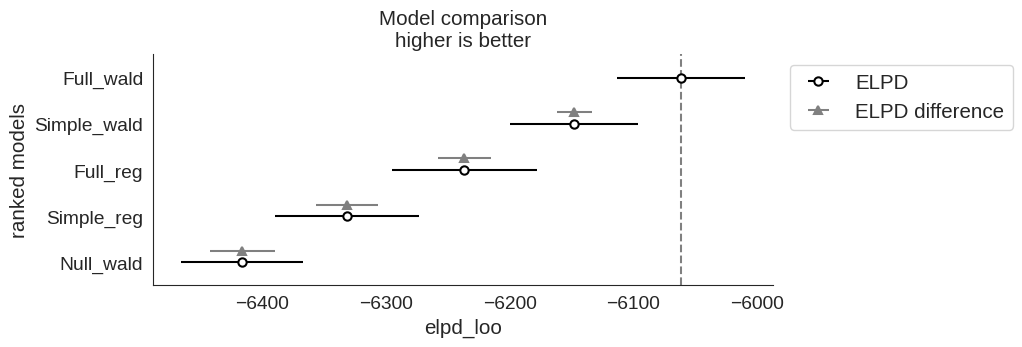

In [21]:

fig, ax = plt.subplots(figsize=(8, 3))
ax = az.plot_compare(cmp, ax =ax)      
#fig = ax.figure     

ax.set_xlabel("elpd_loo")
# --- Optional: clean style ---
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})

sns.despine(ax=ax, top=True, right=True)
#plt.tight_layout()
fig.savefig("../figures/model_comparison.svg", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
cmp 

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Full_wald,0,-6061.648485,70.768869,0.000000,0.943960,51.861367,0.000000,False,log
Simple_wald,1,-6147.515694,58.780234,85.867209,0.000000,51.692623,14.436988,False,log
Full_reg,2,-6236.567486,80.543823,174.919000,0.021019,58.478631,21.402959,False,log
Simple_reg,3,-6331.294302,67.941742,269.645817,0.000000,58.368684,25.253274,False,log
Null_wald,4,-6416.186611,39.678136,354.538126,0.035021,49.342614,26.405810,False,log


In [18]:
wald_loo = az.loo(idata_lognormal)

wald_loo

Computed from 16000 posterior samples and 3295 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6058.27    51.73
p_loo       66.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     3295  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [32]:
reg_loo = az.loo(idata_reg)

reg_loo

Computed from 20000 posterior samples and 3295 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6237.33    58.48
p_loo       81.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     3295  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Paper plots

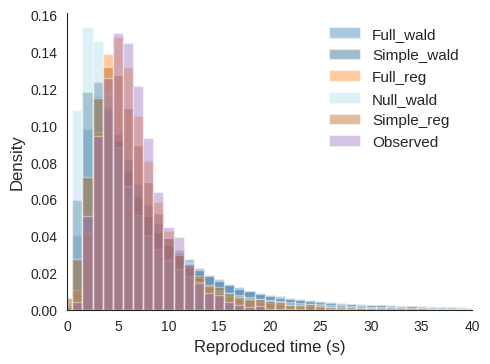

In [44]:
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
})

y_observed = df_processed_reproduction_task_data['ReproducedTime'].values

plt.figure(figsize=(5, 3.75))

# --- Plot both histograms in one axes ---
plt.hist(
    y_prior_wald,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="C0",
    label="Full_wald"
)

plt.hist(
    y_prior_wald_simple,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="#16537e",
    label="Simple_wald"
)

plt.hist(
    y_prior_reg,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="C1",
    label="Full_reg"
)



plt.hist(
    y_prior_wald_null,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="lightblue",
    label="Null_wald"
)




plt.hist(
    y_prior_reg_simple,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="#b2590a",
    label="Simple_reg"
)


plt.hist(
    y_observed,
    bins=np.arange(-0.5, 60.5, 1),
    density=True,
    alpha=0.4,
    color="C4",
    label="Observed"
)


# --- Labels and aesthetics ---
plt.xlabel("Reproduced time (s)", fontsize=12)
plt.ylabel("Density", fontsize=12)
#plt.title("Prior Predictive Distributions", fontsize=14)
plt.xlim(0, 40)
plt.legend(frameon=False, fontsize=11)
sns.despine(top=True, right=True)
plt.tight_layout()

# --- Optional save ---
plt.savefig("../figures/prior_predictive_distributions.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)

plt.show()


In [108]:


# ---------- style ----------
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# ---------- variables ----------
mu_vars = [
    "group_log_beta0_mu",
    "group_log_beta1_mu",
    "group_log_beta2_mu",
    "group_log_drift_mu",
]
sigma_vars = [
    "group_log_beta0_sigma",
    "group_log_beta1_sigma",
    "group_log_beta2_sigma",
    "group_log_drift_sigma",
]

labels_mu    = [r"$\mu_{\beta_0}$", r"$\mu_{\beta_1}$", r"$\mu_{\beta_2}$", r"$\mu_{v_{\text{wm}}}$"]
labels_sigma = [r"$\sigma_{\beta_0}$", r"$\sigma_{\beta_1}$", r"$\sigma_{\beta_2}$", r"$\sigma_{v_{\text{wm}}}$"]

# different color sets for μ and σ
colors_mu    = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]   # C0..C3
colors_sigma = plt.rcParams["axes.prop_cycle"].by_key()["color"][4:8]  # C4..C7

# ---------- figure ----------
fig, axes = plt.subplots(2, 2, figsize=(12, 7), gridspec_kw={"wspace": 0.28, "hspace": 0.5})
(ax_mu_post, ax_mu_trace), (ax_sig_post, ax_sig_trace) = axes

# helpers
def overlay_posteriors(ax, vars_, labels, colors):
    for v, lab, col in zip(vars_, labels, colors):
        samples = idata_wald.posterior[v].stack(sample=("chain", "draw")).values
        az.plot_kde(samples, ax=ax,
                    plot_kwargs={"lw": 2, "color": col},
                    fill_kwargs={"alpha": 0.10, "color": col})
    ax.set_xlabel("Value", fontsize=14); ax.set_ylabel("Density", fontsize=14)

def overlay_traces(ax, vars_, labels, colors, alpha=0.1, lw=0.8, linestyle="-"):
    for v, lab, col in zip(vars_, labels, colors):
        arr = idata_wald.posterior[v].values  # (chain, draw)
        x = np.arange(arr.shape[1])
        for ch in range(arr.shape[0]):
            ax.plot(x, arr[ch], lw=lw, alpha=alpha, color=col, ls=linestyle)
    ax.set_xlabel("Steps", fontsize=14); ax.set_ylabel("Value", fontsize=14)

# ---------- plot ----------
overlay_posteriors(ax_mu_post,  mu_vars,    labels_mu,    colors_mu)
overlay_traces(   ax_mu_trace,  mu_vars,    labels_mu,    colors_mu, linestyle="-")
overlay_posteriors(ax_sig_post, sigma_vars, labels_sigma, colors_sigma)
overlay_traces(   ax_sig_trace, sigma_vars, labels_sigma, colors_sigma, linestyle="--")  # dashed to reinforce σ

# titles
ax_mu_post.set_title(r"Group-level $\mu$ posteriors", fontsize=16)
ax_mu_trace.set_title(r"Group-level $\mu$ traces", fontsize=16)
ax_sig_post.set_title(r"Group-level $\sigma$ posteriors", fontsize=16)
ax_sig_trace.set_title(r"Group-level $\sigma$ traces", fontsize=16)

# clean spines
for row in axes:
    for ax in row:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='both', labelsize=12)


# ---------- single legend on the right ----------
# Make proxy lines so legend shows both μ and σ entries with their colors
proxies = (
    [Line2D([0],[0], color=c, lw=2, ls="-")  for c in colors_mu] +
    [Line2D([0],[0], color=c, lw=2, ls="-") for c in colors_sigma]
)
legend_labels = labels_mu + labels_sigma

# leave room on the right for the legend
fig.subplots_adjust(right=0.80)
fig.legend(proxies, legend_labels, loc="center left", bbox_to_anchor=(0.82, 0.5),
           frameon=False, title="Parameters", title_fontsize=16, fontsize=18)

outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, f"fitted_params_group_level_wald_{wald_prior_class}.png")
plt.savefig(out_figure_path, dpi=300, bbox_inches='tight')
plt.clf()

plt.show()


<Figure size 1200x700 with 0 Axes>

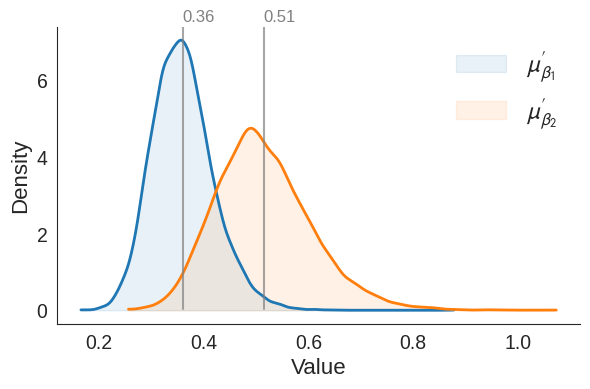

In [9]:
# --- style ---
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# --- extract samples ---
v1 = idata_wald.posterior["group_beta1_mu"].stack(sample=("chain", "draw")).values
v2 = idata_wald.posterior["group_beta2_mu"].stack(sample=("chain", "draw")).values

# --- compute means ---
mean1 = np.mean(v1)
mean2 = np.mean(v2)

# --- create figure ---
fig, ax = plt.subplots(figsize=(6, 4))

# --- plot KDEs ---
az.plot_kde(v1, ax=ax, label=r"$\mu_{\beta_1}^{\prime}$",
            plot_kwargs={"color": "C0", "lw": 2},
            fill_kwargs={"alpha": 0.10, "color": "C0"})

az.plot_kde(v2, ax=ax, label=r"$\mu_{\beta_2}^{\prime}$",
            plot_kwargs={"color": "C1", "lw": 2},
            fill_kwargs={"alpha": 0.10, "color": "C1"})

# --- add mean lines ---
ax.axvline(mean1, color="grey", lw=1.5, ls="-", alpha=0.7, ymin=0.05, ymax=1.0)
ax.axvline(mean2, color="grey", lw=1.5, ls="-", alpha=0.7, ymin=0.05, ymax=1.0)

# --- optional mean annotations ---
ax.text(mean1, ax.get_ylim()[1]*1.06, f"{mean1:.2f}",
        color="grey", rotation=0, va="top", ha="left", fontsize=12)
ax.text(mean2, ax.get_ylim()[1]*1.06, f"{mean2:.2f}",
        color="grey", rotation=0, va="top", ha="left", fontsize=12)

# --- labels and style ---
ax.set_xlabel("Value", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
#ax.set_title("Posterior distributions of μ parameters", fontsize=13)

# Larger legend font
ax.legend(frameon=False, fontsize=18, loc="best")

# Clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
sns.despine()

plt.tight_layout()
plt.show()


95% HDI for v3: [-0.36926073  0.04271199]


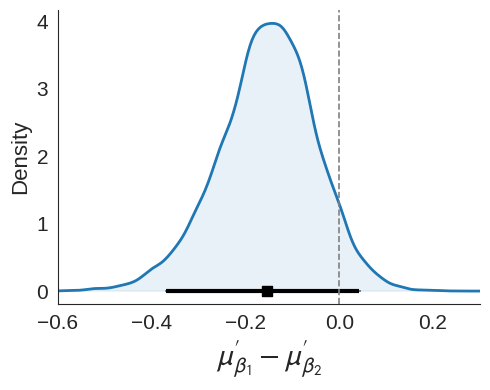

Posterior mass below 0: 0.941 (94.1%)


In [26]:
# --- style ---
sns.set_style("white")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans"],
    "text.usetex": False,
    "mathtext.fontset": "stixsans",
})

# --- extract samples ---
v1 = idata_wald.posterior["group_beta1_mu"].stack(sample=("chain", "draw")).values
v2 = idata_wald.posterior["group_beta2_mu"].stack(sample=("chain", "draw")).values

v3 = v1 - v2

# --- compute means ---
mean1 = np.mean(v1)
mean2 = np.mean(v2)
mean3 = np.mean(v3)   # this is the one we’ll plot

# --- create figure ---
fig, ax = plt.subplots(figsize=(5, 4))

# --- plot KDEs ---
az.plot_kde(
    v3,
    ax=ax,
    #label=r"$\mu_{\beta_2} - \mu_{\beta_1}$",
    plot_kwargs={"color": "C0", "lw": 2},
    fill_kwargs={"alpha": 0.10, "color": "C0"},
)

# --- labels and style ---
ax.set_xlabel(r"$\mu_{\beta_1}^{\prime} - \mu_{\beta_2}^{\prime}$", fontsize=22)
ax.set_ylabel("Density", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=15)


# --- HDI ---
hdi_95 = az.hdi(v3, hdi_prob=0.95)
lower, upper = hdi_95
print("95% HDI for v3:", hdi_95)

# draw HDI line on x-axis
ax.hlines(y=0, xmin=lower, xmax=upper, colors="k", linewidth=3)

# optional: small ticks at the ends
ax.vlines([lower, upper], ymin=0, ymax=0.01, colors="k", linewidth=2)

# --- mean marker on the HDI line ---
ax.scatter(mean3, 0, marker="s", color="k", s=60, zorder=5)

# --- vertical line at x = 0 ---
ax.axvline(0, color="grey", linestyle="--", linewidth=1.2)

# Clean look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
sns.despine()
plt.xlim(-0.6,0.3)
plt.tight_layout()


outdir_figures = "../figures"
os.makedirs(outdir_figures, exist_ok=True)
out_figure_path = os.path.join(outdir_figures, f"mu1_minus_mu2_group_level_wald_{wald_prior_class}.svg")

plt.savefig(out_figure_path, format="svg", bbox_inches="tight")


plt.show()


p_neg = np.mean(v3 < 0)   # this is the posterior probability v3 < 0
print(f"Posterior mass below 0: {p_neg:.3f} ({p_neg*100:.1f}%)")